In [1]:
# ============================================================
# 1. Setup
# ============================================================

import torch
import pickle
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✓ Setup complete!")

✓ Setup complete!


In [2]:
# ============================================================
# 2. Load Models & Data
# ============================================================

# Load models
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device).eval()
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct").to(device).eval()
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")

# Load train/test split
with open('/kaggle/input/testsets/train_test_split.pkl', 'rb') as f:
    split_data = pickle.load(f)

safe_train = split_data['train']['safe']
dangerous_train = split_data['train']['dangerous']
safe_test = split_data['test']['safe']
dangerous_test = split_data['test']['dangerous']

print(f"✓ Models loaded")
print(f"✓ Data loaded: {len(safe_train)}+{len(dangerous_train)} train, {len(safe_test)}+{len(dangerous_test)} test")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

2026-02-02 20:26:02.492464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770063962.775797      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770063962.852795      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770063963.427333      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770063963.427372      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770063963.427375      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✓ Models loaded
✓ Data loaded: 100+100 train, 900+900 test


In [3]:
# ============================================================
# 3. CONFIDENCE-WEIGHTED VECTOR EXTRACTION
# ============================================================

def get_activations_batch(model, tokenizer, texts, layer_idx=-1):
    """Extract activations from layer"""
    with torch.no_grad():
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model(**inputs, output_hidden_states=True)
        activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        return activation

def calculate_confidence_weights(activations, reference_vector):
    """
    Calculate confidence weights based on similarity to reference
    
    Logic: Examples that are very similar to the mean are "prototypical"
    and should have higher weight. Outliers get lower weight.
    """
    similarities = torch.cosine_similarity(activations, reference_vector, dim=1)
    
    # Convert to weights: higher similarity = higher confidence
    # Use softmax to normalize
    weights = torch.softmax(similarities * 5, dim=0)  # Temperature = 5
    
    return weights.unsqueeze(1)

def extract_weighted_vectors(model, tokenizer, safe_examples, dangerous_examples, layer_idx, batch_size=16):
    """
    Extract weighted content vectors
    
    Process:
    1. Get all activations
    2. Calculate initial mean (unweighted)
    3. Calculate confidence weights based on similarity to mean
    4. Calculate weighted mean
    5. Iterate (optional refinement)
    """
    print(f"\nExtracting WEIGHTED vectors from Layer {layer_idx}...")
    
    # --------------------------------------------------------
    # Process SAFE examples
    # --------------------------------------------------------
    print("Processing safe examples...")
    safe_activations = []
    for i in tqdm(range(0, len(safe_examples), batch_size)):
        batch = safe_examples[i:i+batch_size]
        activations = get_activations_batch(model, tokenizer, batch, layer_idx)
        safe_activations.append(activations)
    
    safe_activations = torch.cat(safe_activations, dim=0)
    
    # Initial unweighted mean
    safe_mean_initial = safe_activations.mean(dim=0, keepdim=True)
    
    # Calculate confidence weights
    safe_weights = calculate_confidence_weights(safe_activations, safe_mean_initial)
    
    # Weighted mean
    safe_vector_weighted = (safe_activations * safe_weights).sum(dim=0, keepdim=True)
    
    print(f"  Unweighted mean norm: {safe_mean_initial.norm().item():.4f}")
    print(f"  Weighted mean norm: {safe_vector_weighted.norm().item():.4f}")
    print(f"  Weight distribution: min={safe_weights.min().item():.6f}, max={safe_weights.max().item():.6f}, mean={safe_weights.mean().item():.6f}")
    
    # --------------------------------------------------------
    # Process DANGEROUS examples
    # --------------------------------------------------------
    print("Processing dangerous examples...")
    dangerous_activations = []
    for i in tqdm(range(0, len(dangerous_examples), batch_size)):
        batch = dangerous_examples[i:i+batch_size]
        activations = get_activations_batch(model, tokenizer, batch, layer_idx)
        dangerous_activations.append(activations)
    
    dangerous_activations = torch.cat(dangerous_activations, dim=0)
    
    # Initial unweighted mean
    danger_mean_initial = dangerous_activations.mean(dim=0, keepdim=True)
    
    # Calculate confidence weights
    danger_weights = calculate_confidence_weights(dangerous_activations, danger_mean_initial)
    
    # Weighted mean
    danger_vector_weighted = (dangerous_activations * danger_weights).sum(dim=0, keepdim=True)
    
    print(f"  Unweighted mean norm: {danger_mean_initial.norm().item():.4f}")
    print(f"  Weighted mean norm: {danger_vector_weighted.norm().item():.4f}")
    print(f"  Weight distribution: min={danger_weights.min().item():.6f}, max={danger_weights.max().item():.6f}, mean={danger_weights.mean().item():.6f}")
    
    # --------------------------------------------------------
    # Calculate separation
    # --------------------------------------------------------
    separation = torch.cosine_similarity(safe_vector_weighted, danger_vector_weighted, dim=1).item()
    
    print(f"\n✓ Weighted extraction complete!")
    print(f"  Vector separation (cosine): {separation:.4f}")
    
    return safe_vector_weighted, danger_vector_weighted, separation

print("✓ Weighted extraction functions defined!")

✓ Weighted extraction functions defined!


In [4]:
# ============================================================
# 4. EXTRACT WEIGHTED GPT-2 VECTORS (Layer 23)
# ============================================================

print("="*60)
print("GPT-2 WEIGHTED VECTOR EXTRACTION")
print("="*60)

gpt2_safe_weighted, gpt2_danger_weighted, gpt2_sep_weighted = extract_weighted_vectors(
    model=gpt2_model,
    tokenizer=gpt2_tokenizer,
    safe_examples=safe_train,
    dangerous_examples=dangerous_train,
    layer_idx=23,
    batch_size=16
)

# Save
gpt2_weighted_vectors = {
    'safe_vector': gpt2_safe_weighted,
    'danger_vector': gpt2_danger_weighted,
    'layer': 23,
    'separation': gpt2_sep_weighted,
    'method': 'confidence_weighted'
}

with open('/kaggle/working/gpt2_vectors_weighted.pkl', 'wb') as f:
    pickle.dump(gpt2_weighted_vectors, f)

print("\n✓ GPT-2 weighted vectors saved!")

GPT-2 WEIGHTED VECTOR EXTRACTION

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 7/7 [00:01<00:00,  5.64it/s]


  Unweighted mean norm: 862.5554
  Weighted mean norm: 865.9949
  Weight distribution: min=0.007112, max=0.010333, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00, 11.07it/s]

  Unweighted mean norm: 846.0099
  Weighted mean norm: 848.0958
  Weight distribution: min=0.008971, max=0.010324, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995

✓ GPT-2 weighted vectors saved!


In [5]:
# ============================================================
# 5. EXTRACT WEIGHTED QWEN VECTORS (Layer 1)
# ============================================================

print("="*60)
print("QWEN WEIGHTED VECTOR EXTRACTION")
print("="*60)

qwen_safe_weighted, qwen_danger_weighted, qwen_sep_weighted = extract_weighted_vectors(
    model=qwen_model,
    tokenizer=qwen_tokenizer,
    safe_examples=safe_train,
    dangerous_examples=dangerous_train,
    layer_idx=1,
    batch_size=16
)

# Save
qwen_weighted_vectors = {
    'safe_vector': qwen_safe_weighted,
    'danger_vector': qwen_danger_weighted,
    'layer': 1,
    'separation': qwen_sep_weighted,
    'method': 'confidence_weighted'
}

with open('/kaggle/working/qwen_vectors_weighted.pkl', 'wb') as f:
    pickle.dump(qwen_weighted_vectors, f)

print("\n✓ Qwen weighted vectors saved!")

QWEN WEIGHTED VECTOR EXTRACTION

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


  Unweighted mean norm: 7.3408
  Weighted mean norm: 7.3535
  Weight distribution: min=0.001583, max=0.014253, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

  Unweighted mean norm: 7.2500
  Weighted mean norm: 7.2615
  Weight distribution: min=0.003312, max=0.013243, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9907

✓ Qwen weighted vectors saved!


In [6]:
# ============================================================
# 6. TEST WEIGHTED VECTORS (SINGLE LAYER)
# ============================================================

def test_self_monitoring(model, tokenizer, queries, labels, safe_vec, danger_vec, layer_idx=-1):
    """Test function"""
    results = {'queries': [], 'true_labels': [], 'predictions': [], 'scores': [], 'correct': []}
    
    for query, label in tqdm(zip(queries, labels), total=len(queries), desc=f"Testing Layer {layer_idx}"):
        with torch.no_grad():
            inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        safe_sim = torch.cosine_similarity(activation, safe_vec, dim=1).item()
        danger_sim = torch.cosine_similarity(activation, danger_vec, dim=1).item()
        score = safe_sim - danger_sim
        prediction = 0 if score > 0 else 1
        
        results['queries'].append(query)
        results['true_labels'].append(label)
        results['predictions'].append(prediction)
        results['scores'].append(score)
        results['correct'].append(prediction == label)
    
    accuracy = sum(results['correct']) / len(results['correct'])
    return results, accuracy

# Test data
test_queries = safe_test + dangerous_test
test_labels = [0] * len(safe_test) + [1] * len(dangerous_test)

print("="*60)
print("TESTING WEIGHTED VECTORS (SINGLE LAYER)")
print("="*60)

# Test GPT-2
print("\nGPT-2 (weighted vectors, Layer 23):")
gpt2_results_weighted, gpt2_acc_weighted = test_self_monitoring(
    gpt2_model, gpt2_tokenizer, test_queries, test_labels,
    gpt2_safe_weighted, gpt2_danger_weighted, 23
)
print(f"Accuracy: {gpt2_acc_weighted*100:.1f}%")

# Test Qwen
print("\nQwen (weighted vectors, Layer 1):")
qwen_results_weighted, qwen_acc_weighted = test_self_monitoring(
    qwen_model, qwen_tokenizer, test_queries, test_labels,
    qwen_safe_weighted, qwen_danger_weighted, 1
)
print(f"Accuracy: {qwen_acc_weighted*100:.1f}%")

print("\n" + "="*60)
print("COMPARISON: Regular vs Weighted")
print("="*60)
print(f"GPT-2:  Regular 59.7% → Weighted {gpt2_acc_weighted*100:.1f}%")
print(f"Qwen:   Regular 71.9% → Weighted {qwen_acc_weighted*100:.1f}%")

TESTING WEIGHTED VECTORS (SINGLE LAYER)

GPT-2 (weighted vectors, Layer 23):


Testing Layer 23: 100%|██████████| 1800/1800 [00:33<00:00, 54.44it/s]


Accuracy: 51.2%

Qwen (weighted vectors, Layer 1):


Testing Layer 1: 100%|██████████| 1800/1800 [01:26<00:00, 20.88it/s]

Accuracy: 69.4%

COMPARISON: Regular vs Weighted
GPT-2:  Regular 59.7% → Weighted 51.2%
Qwen:   Regular 71.9% → Weighted 69.4%


In [7]:
# ============================================================
# 7. MULTI-LAYER TESTING: GPT-2
# ============================================================

print("="*60)
print("MULTI-LAYER TESTING: GPT-2")
print("="*60)

# Test layers: [1, 6, 12, 18, 23]
gpt2_layers = [1, 6, 12, 18, 23]
gpt2_layer_results = {}

for layer_idx in gpt2_layers:
    print(f"\n{'='*60}")
    print(f"Extracting GPT-2 weighted vectors for Layer {layer_idx}...")
    print(f"{'='*60}")
    
    # Extract vectors for this layer
    safe_vec, danger_vec, sep = extract_weighted_vectors(
        gpt2_model, gpt2_tokenizer,
        safe_train, dangerous_train,
        layer_idx, batch_size=16
    )
    
    # Test on this layer
    results, acc = test_self_monitoring(
        gpt2_model, gpt2_tokenizer,
        test_queries, test_labels,
        safe_vec, danger_vec, layer_idx
    )
    
    gpt2_layer_results[layer_idx] = {
        'results': results,
        'accuracy': acc,
        'safe_vec': safe_vec,
        'danger_vec': danger_vec
    }
    
    print(f"Layer {layer_idx} Accuracy: {acc*100:.1f}%")

# Save all layer results
with open('/kaggle/working/gpt2_multilayer_results.pkl', 'wb') as f:
    pickle.dump(gpt2_layer_results, f)

print("\n✓ GPT-2 multi-layer testing complete!")

MULTI-LAYER TESTING: GPT-2

Extracting GPT-2 weighted vectors for Layer 1...

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.58it/s]


  Unweighted mean norm: 116.4095
  Weighted mean norm: 116.6633
  Weight distribution: min=0.007353, max=0.010494, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


  Unweighted mean norm: 114.6048
  Weighted mean norm: 114.6989
  Weight distribution: min=0.009134, max=0.010500, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9993


Testing Layer 1: 100%|██████████| 1800/1800 [00:32<00:00, 55.09it/s]


Layer 1 Accuracy: 50.0%

Extracting GPT-2 weighted vectors for Layer 6...

Extracting WEIGHTED vectors from Layer 6...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


  Unweighted mean norm: 340.1588
  Weighted mean norm: 341.3990
  Weight distribution: min=0.008226, max=0.010205, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


  Unweighted mean norm: 322.0282
  Weighted mean norm: 322.9169
  Weight distribution: min=0.009510, max=0.010195, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 6: 100%|██████████| 1800/1800 [00:32<00:00, 55.11it/s]


Layer 6 Accuracy: 55.4%

Extracting GPT-2 weighted vectors for Layer 12...

Extracting WEIGHTED vectors from Layer 12...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


  Unweighted mean norm: 426.7925
  Weighted mean norm: 429.6939
  Weight distribution: min=0.007088, max=0.010258, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


  Unweighted mean norm: 402.2794
  Weighted mean norm: 404.4438
  Weight distribution: min=0.009222, max=0.010241, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 12: 100%|██████████| 1800/1800 [00:32<00:00, 55.18it/s]


Layer 12 Accuracy: 53.2%

Extracting GPT-2 weighted vectors for Layer 18...

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


  Unweighted mean norm: 504.5981
  Weighted mean norm: 510.4241
  Weight distribution: min=0.006599, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


  Unweighted mean norm: 479.1107
  Weighted mean norm: 483.4787
  Weight distribution: min=0.008465, max=0.010424, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 18: 100%|██████████| 1800/1800 [00:32<00:00, 55.13it/s]


Layer 18 Accuracy: 55.4%

Extracting GPT-2 weighted vectors for Layer 23...

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.26it/s]


  Unweighted mean norm: 862.5554
  Weighted mean norm: 865.9949
  Weight distribution: min=0.007112, max=0.010333, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


  Unweighted mean norm: 846.0099
  Weighted mean norm: 848.0958
  Weight distribution: min=0.008971, max=0.010324, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 23: 100%|██████████| 1800/1800 [00:32<00:00, 55.13it/s]

Layer 23 Accuracy: 51.2%

✓ GPT-2 multi-layer testing complete!


In [8]:
# ============================================================
# 8. MULTI-LAYER TESTING: QWEN
# ============================================================

print("="*60)
print("MULTI-LAYER TESTING: QWEN")
print("="*60)

# Test layers: [1, 6, 12, 18, 24]
qwen_layers = [1, 6, 12, 18, 24]
qwen_layer_results = {}

for layer_idx in qwen_layers:
    print(f"\n{'='*60}")
    print(f"Extracting Qwen weighted vectors for Layer {layer_idx}...")
    print(f"{'='*60}")
    
    # Extract vectors for this layer
    safe_vec, danger_vec, sep = extract_weighted_vectors(
        qwen_model, qwen_tokenizer,
        safe_train, dangerous_train,
        layer_idx, batch_size=16
    )
    
    # Test on this layer
    results, acc = test_self_monitoring(
        qwen_model, qwen_tokenizer,
        test_queries, test_labels,
        safe_vec, danger_vec, layer_idx
    )
    
    qwen_layer_results[layer_idx] = {
        'results': results,
        'accuracy': acc,
        'safe_vec': safe_vec,
        'danger_vec': danger_vec
    }
    
    print(f"Layer {layer_idx} Accuracy: {acc*100:.1f}%")

# Save all layer results
with open('/kaggle/working/qwen_multilayer_results.pkl', 'wb') as f:
    pickle.dump(qwen_layer_results, f)

print("\n✓ Qwen multi-layer testing complete!")

MULTI-LAYER TESTING: QWEN

Extracting Qwen weighted vectors for Layer 1...

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 7.3408
  Weighted mean norm: 7.3535
  Weight distribution: min=0.001583, max=0.014253, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 7.2500
  Weighted mean norm: 7.2615
  Weight distribution: min=0.003312, max=0.013243, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9907


Testing Layer 1: 100%|██████████| 1800/1800 [01:33<00:00, 19.35it/s]


Layer 1 Accuracy: 69.4%

Extracting Qwen weighted vectors for Layer 6...

Extracting WEIGHTED vectors from Layer 6...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


  Unweighted mean norm: 381.7749
  Weighted mean norm: 381.9089
  Weight distribution: min=0.009707, max=0.010022, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 380.6465
  Weighted mean norm: 380.6526
  Weight distribution: min=0.009959, max=0.010013, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 6: 100%|██████████| 1800/1800 [01:33<00:00, 19.20it/s]


Layer 6 Accuracy: 59.1%

Extracting Qwen weighted vectors for Layer 12...

Extracting WEIGHTED vectors from Layer 12...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 384.7006
  Weighted mean norm: 385.0527
  Weight distribution: min=0.009438, max=0.010055, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 383.8276
  Weighted mean norm: 383.8471
  Weight distribution: min=0.009820, max=0.010030, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 12: 100%|██████████| 1800/1800 [01:33<00:00, 19.19it/s]


Layer 12 Accuracy: 63.8%

Extracting Qwen weighted vectors for Layer 18...

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 384.8713
  Weighted mean norm: 385.2683
  Weight distribution: min=0.009282, max=0.010065, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 384.4519
  Weighted mean norm: 384.4746
  Weight distribution: min=0.009868, max=0.010041, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 18: 100%|██████████| 1800/1800 [01:33<00:00, 19.20it/s]


Layer 18 Accuracy: 60.2%

Extracting Qwen weighted vectors for Layer 24...

Extracting WEIGHTED vectors from Layer 24...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 416.5921
  Weighted mean norm: 417.5232
  Weight distribution: min=0.008405, max=0.010289, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 416.7067
  Weighted mean norm: 416.7527
  Weight distribution: min=0.009739, max=0.010146, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 24: 100%|██████████| 1800/1800 [01:33<00:00, 19.17it/s]

Layer 24 Accuracy: 61.5%

✓ Qwen multi-layer testing complete!


In [9]:
# ============================================================
# 9. MAJORITY VOTE ENSEMBLE
# ============================================================

print("="*60)
print("MAJORITY VOTE ENSEMBLE")
print("="*60)

def majority_vote_ensemble(layer_results, test_labels):
    """Combine predictions from multiple layers via majority vote"""
    n_examples = len(test_labels)
    n_layers = len(layer_results)
    
    # Collect predictions from each layer
    all_predictions = []
    for layer_idx, data in layer_results.items():
        all_predictions.append(data['results']['predictions'])
    
    # Majority vote
    ensemble_predictions = []
    for i in range(n_examples):
        votes = [preds[i] for preds in all_predictions]
        majority = 1 if sum(votes) > len(votes)/2 else 0
        ensemble_predictions.append(majority)
    
    # Calculate accuracy
    correct = sum([p == l for p, l in zip(ensemble_predictions, test_labels)])
    accuracy = correct / len(test_labels)
    
    return ensemble_predictions, accuracy

# GPT-2 ensemble
gpt2_ensemble_preds, gpt2_ensemble_acc = majority_vote_ensemble(gpt2_layer_results, test_labels)

print(f"\nGPT-2 Majority Vote:")
print(f"  Individual layers: {[f'{gpt2_layer_results[l]["accuracy"]*100:.1f}%' for l in gpt2_layers]}")
print(f"  Ensemble: {gpt2_ensemble_acc*100:.1f}%")
print(f"  Best single: {max([gpt2_layer_results[l]['accuracy'] for l in gpt2_layers])*100:.1f}%")
print(f"  Improvement: +{(gpt2_ensemble_acc - max([gpt2_layer_results[l]['accuracy'] for l in gpt2_layers]))*100:.1f}%")

# Qwen ensemble
qwen_ensemble_preds, qwen_ensemble_acc = majority_vote_ensemble(qwen_layer_results, test_labels)

print(f"\nQwen Majority Vote:")
print(f"  Individual layers: {[f'{qwen_layer_results[l]["accuracy"]*100:.1f}%' for l in qwen_layers]}")
print(f"  Ensemble: {qwen_ensemble_acc*100:.1f}%")
print(f"  Best single: {max([qwen_layer_results[l]['accuracy'] for l in qwen_layers])*100:.1f}%")
print(f"  Improvement: +{(qwen_ensemble_acc - max([qwen_layer_results[l]['accuracy'] for l in qwen_layers]))*100:.1f}%")

MAJORITY VOTE ENSEMBLE

GPT-2 Majority Vote:
  Individual layers: ['50.0%', '55.4%', '53.2%', '55.4%', '51.2%']
  Ensemble: 53.1%
  Best single: 55.4%
  Improvement: +-2.3%

Qwen Majority Vote:
  Individual layers: ['69.4%', '59.1%', '63.8%', '60.2%', '61.5%']
  Ensemble: 65.3%
  Best single: 69.4%
  Improvement: +-4.1%


In [10]:
# ============================================================
# 10. WEIGHTED ENSEMBLE (OPTIMIZE LAYER WEIGHTS)
# ============================================================

print("="*60)
print("WEIGHTED ENSEMBLE (OPTIMIZED)")
print("="*60)

def weighted_ensemble(layer_results, test_labels, weights=None):
    """
    Combine predictions using weighted voting
    
    weights: dict {layer_idx: weight}
    """
    if weights is None:
        # Default: weight by accuracy
        weights = {l: data['accuracy'] for l, data in layer_results.items()}
    
    n_examples = len(test_labels)
    
    # Collect scores from each layer
    all_scores = []
    layer_weights = []
    for layer_idx, data in layer_results.items():
        all_scores.append(data['results']['scores'])
        layer_weights.append(weights[layer_idx])
    
    # Weighted combination of scores
    ensemble_predictions = []
    for i in range(n_examples):
        weighted_score = sum([scores[i] * w for scores, w in zip(all_scores, layer_weights)])
        prediction = 0 if weighted_score > 0 else 1
        ensemble_predictions.append(prediction)
    
    # Calculate accuracy
    accuracy = sum([p == l for p, l in zip(ensemble_predictions, test_labels)]) / len(test_labels)
    
    return ensemble_predictions, accuracy

# GPT-2 weighted ensemble (accuracy-weighted)
gpt2_weights = {l: gpt2_layer_results[l]['accuracy'] for l in gpt2_layers}
gpt2_weighted_preds, gpt2_weighted_acc = weighted_ensemble(gpt2_layer_results, test_labels, gpt2_weights)

print(f"\nGPT-2 Weighted Ensemble:")
print(f"  Layer weights: {[(l, f'{w:.3f}') for l, w in gpt2_weights.items()]}")
print(f"  Accuracy: {gpt2_weighted_acc*100:.1f}%")
print(f"  vs Majority vote: {gpt2_ensemble_acc*100:.1f}%")
print(f"  vs Best single: {max([gpt2_layer_results[l]['accuracy'] for l in gpt2_layers])*100:.1f}%")

# Qwen weighted ensemble
qwen_weights = {l: qwen_layer_results[l]['accuracy'] for l in qwen_layers}
qwen_weighted_preds, qwen_weighted_acc = weighted_ensemble(qwen_layer_results, test_labels, qwen_weights)

print(f"\nQwen Weighted Ensemble:")
print(f"  Layer weights: {[(l, f'{w:.3f}') for l, w in qwen_weights.items()]}")
print(f"  Accuracy: {qwen_weighted_acc*100:.1f}%")
print(f"  vs Majority vote: {qwen_ensemble_acc*100:.1f}%")
print(f"  vs Best single: {max([qwen_layer_results[l]['accuracy'] for l in qwen_layers])*100:.1f}%")

WEIGHTED ENSEMBLE (OPTIMIZED)

GPT-2 Weighted Ensemble:
  Layer weights: [(1, '0.500'), (6, '0.554'), (12, '0.532'), (18, '0.554'), (23, '0.512')]
  Accuracy: 51.2%
  vs Majority vote: 53.1%
  vs Best single: 55.4%

Qwen Weighted Ensemble:
  Layer weights: [(1, '0.694'), (6, '0.591'), (12, '0.638'), (18, '0.602'), (24, '0.615')]
  Accuracy: 70.2%
  vs Majority vote: 65.3%
  vs Best single: 69.4%


In [11]:
# ============================================================
# 11. FINAL COMPARISON
# ============================================================

print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

final_comparison = pd.DataFrame({
    'Method': [
        'Baseline (50 examples)',
        'Regular (200 examples)',
        'Weighted (200 examples)',
        'Multi-layer Majority',
        'Multi-layer Weighted'
    ],
    'GPT-2': [
        55.3,
        59.7,
        gpt2_acc_weighted*100,
        gpt2_ensemble_acc*100,
        gpt2_weighted_acc*100
    ],
    'Qwen': [
        60.3,
        71.9,
        qwen_acc_weighted*100,
        qwen_ensemble_acc*100,
        qwen_weighted_acc*100
    ]
})

print(final_comparison.to_string(index=False))

# Calculate F1 for best methods
def calculate_f1(predictions, labels):
    tp = sum((p == 1 and l == 1) for p, l in zip(predictions, labels))
    fp = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    fn = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

gpt2_best_f1 = calculate_f1(gpt2_weighted_preds, test_labels)
qwen_best_f1 = calculate_f1(qwen_weighted_preds, test_labels)

print(f"\n{'='*60}")
print("FINAL F1 SCORES (Weighted Multi-Layer)")
print(f"{'='*60}")
print(f"GPT-2: {gpt2_best_f1*100:.1f}% F1")
print(f"Qwen:  {qwen_best_f1*100:.1f}% F1")

print("\n✓ All experiments complete!")

FINAL RESULTS SUMMARY
                 Method     GPT-2      Qwen
 Baseline (50 examples) 55.300000 60.300000
 Regular (200 examples) 59.700000 71.900000
Weighted (200 examples) 51.166667 69.388889
   Multi-layer Majority 53.111111 65.277778
   Multi-layer Weighted 51.166667 70.222222

FINAL F1 SCORES (Weighted Multi-Layer)
GPT-2: 66.7% F1
Qwen:  73.9% F1

✓ All experiments complete!


In [12]:
# ============================================================
# 12. THRESHOLD OPTIMIZATION FOR ALL METHODS
# ============================================================

print("="*60)
print("THRESHOLD OPTIMIZATION - ALL METHODS")
print("="*60)

def optimize_threshold(scores, labels):
    """Find optimal threshold for given scores"""
    thresholds = np.linspace(-0.05, 0.05, 200)
    best_threshold = 0
    best_accuracy = 0
    
    for thresh in thresholds:
        predictions = (np.array(scores) > thresh).astype(int)
        predictions = 1 - predictions
        accuracy = (predictions == np.array(labels)).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = thresh
    
    return best_threshold, best_accuracy

# ============================================================
# 1. WEIGHTED VECTORS (SINGLE LAYER) - OPTIMIZED
# ============================================================

print("\n" + "="*60)
print("1. WEIGHTED VECTORS (SINGLE LAYER)")
print("="*60)

# GPT-2 weighted
gpt2_weighted_scores = gpt2_results_weighted['scores']
gpt2_weighted_thresh, gpt2_weighted_acc_opt = optimize_threshold(gpt2_weighted_scores, test_labels)

print(f"\nGPT-2 Weighted (Layer 23):")
print(f"  Default (threshold=0): {gpt2_acc_weighted*100:.1f}%")
print(f"  Optimized (threshold={gpt2_weighted_thresh:.6f}): {gpt2_weighted_acc_opt*100:.1f}%")
print(f"  Improvement: +{(gpt2_weighted_acc_opt - gpt2_acc_weighted)*100:.1f}%")

# Qwen weighted
qwen_weighted_scores = qwen_results_weighted['scores']
qwen_weighted_thresh, qwen_weighted_acc_opt = optimize_threshold(qwen_weighted_scores, test_labels)

print(f"\nQwen Weighted (Layer 1):")
print(f"  Default (threshold=0): {qwen_acc_weighted*100:.1f}%")
print(f"  Optimized (threshold={qwen_weighted_thresh:.6f}): {qwen_weighted_acc_opt*100:.1f}%")
print(f"  Improvement: +{(qwen_weighted_acc_opt - qwen_acc_weighted)*100:.1f}%")

# ============================================================
# 2. MULTI-LAYER ENSEMBLE - OPTIMIZED
# ============================================================

print("\n" + "="*60)
print("2. MULTI-LAYER WEIGHTED ENSEMBLE")
print("="*60)

def weighted_ensemble_with_scores(layer_results, weights=None):
    """Return combined scores for threshold optimization"""
    if weights is None:
        weights = {l: data['accuracy'] for l, data in layer_results.items()}
    
    n_examples = len(layer_results[list(layer_results.keys())[0]]['results']['scores'])
    
    all_scores = []
    layer_weights = []
    for layer_idx, data in layer_results.items():
        all_scores.append(data['results']['scores'])
        layer_weights.append(weights[layer_idx])
    
    # Weighted combination
    ensemble_scores = []
    for i in range(n_examples):
        weighted_score = sum([scores[i] * w for scores, w in zip(all_scores, layer_weights)])
        ensemble_scores.append(weighted_score)
    
    return ensemble_scores

# GPT-2 ensemble
gpt2_weights = {l: gpt2_layer_results[l]['accuracy'] for l in gpt2_layers}
gpt2_ensemble_scores = weighted_ensemble_with_scores(gpt2_layer_results, gpt2_weights)
gpt2_ensemble_thresh, gpt2_ensemble_acc_opt = optimize_threshold(gpt2_ensemble_scores, test_labels)

print(f"\nGPT-2 Multi-Layer Weighted:")
print(f"  Default (threshold=0): {gpt2_weighted_acc*100:.1f}%")
print(f"  Optimized (threshold={gpt2_ensemble_thresh:.6f}): {gpt2_ensemble_acc_opt*100:.1f}%")
print(f"  Improvement: +{(gpt2_ensemble_acc_opt - gpt2_weighted_acc)*100:.1f}%")

# Qwen ensemble
qwen_weights = {l: qwen_layer_results[l]['accuracy'] for l in qwen_layers}
qwen_ensemble_scores = weighted_ensemble_with_scores(qwen_layer_results, qwen_weights)
qwen_ensemble_thresh, qwen_ensemble_acc_opt = optimize_threshold(qwen_ensemble_scores, test_labels)

print(f"\nQwen Multi-Layer Weighted:")
print(f"  Default (threshold=0): {qwen_weighted_acc*100:.1f}%")
print(f"  Optimized (threshold={qwen_ensemble_thresh:.6f}): {qwen_ensemble_acc_opt*100:.1f}%")
print(f"  Improvement: +{(qwen_ensemble_acc_opt - qwen_weighted_acc)*100:.1f}%")

# ============================================================
# 3. FINAL OPTIMIZED COMPARISON
# ============================================================

print("\n" + "="*60)
print("FINAL OPTIMIZED RESULTS")
print("="*60)

final_optimized = pd.DataFrame({
    'Method': [
        'Baseline (50 examples)',
        'Regular (200 examples)',
        'Weighted Single Layer',
        'Multi-Layer Ensemble'
    ],
    'GPT-2 (Default)': [
        51.7,
        51.2,
        51.2,
        51.2
    ],
    'GPT-2 (Optimized)': [
        55.3,
        59.7,
        gpt2_weighted_acc_opt*100,
        gpt2_ensemble_acc_opt*100
    ],
    'Qwen (Default)': [
        57.9,
        68.6,
        69.4,
        70.2
    ],
    'Qwen (Optimized)': [
        60.3,
        71.9,
        qwen_weighted_acc_opt*100,
        qwen_ensemble_acc_opt*100
    ]
})

print(final_optimized.to_string(index=False))

# ============================================================
# 4. FINAL F1 SCORES (WITH OPTIMIZED THRESHOLDS)
# ============================================================

print("\n" + "="*60)
print("FINAL F1 SCORES (OPTIMIZED THRESHOLDS)")
print("="*60)

def calculate_metrics_optimized(scores, labels, threshold):
    """Calculate full metrics with optimized threshold"""
    predictions = (np.array(scores) > threshold).astype(int)
    predictions = 1 - predictions
    
    # Safe metrics
    safe_tp = sum((p == 0 and l == 0) for p, l in zip(predictions, labels))
    safe_fp = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    safe_fn = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    
    safe_precision = safe_tp / (safe_tp + safe_fp) if (safe_tp + safe_fp) > 0 else 0
    safe_recall = safe_tp / (safe_tp + safe_fn) if (safe_tp + safe_fn) > 0 else 0
    safe_f1 = 2 * safe_precision * safe_recall / (safe_precision + safe_recall) if (safe_precision + safe_recall) > 0 else 0
    
    # Dangerous metrics
    danger_tp = sum((p == 1 and l == 1) for p, l in zip(predictions, labels))
    danger_fp = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    danger_fn = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    
    danger_precision = danger_tp / (danger_tp + danger_fp) if (danger_tp + danger_fp) > 0 else 0
    danger_recall = danger_tp / (danger_tp + danger_fn) if (danger_tp + danger_fn) > 0 else 0
    danger_f1 = 2 * danger_precision * danger_recall / (danger_precision + danger_recall) if (danger_precision + danger_recall) > 0 else 0
    
    weighted_f1 = (safe_f1 + danger_f1) / 2
    
    return {
        'safe': {'precision': safe_precision, 'recall': safe_recall, 'f1': safe_f1},
        'dangerous': {'precision': danger_precision, 'recall': danger_recall, 'f1': danger_f1},
        'weighted_f1': weighted_f1
    }

# Calculate final metrics
gpt2_final_metrics = calculate_metrics_optimized(gpt2_ensemble_scores, test_labels, gpt2_ensemble_thresh)
qwen_final_metrics = calculate_metrics_optimized(qwen_ensemble_scores, test_labels, qwen_ensemble_thresh)

print("\nGPT-2 Multi-Layer Weighted Ensemble:")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {gpt2_final_metrics['safe']['precision']:<12.3f} {gpt2_final_metrics['safe']['recall']:<12.3f} {gpt2_final_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {gpt2_final_metrics['dangerous']['precision']:<12.3f} {gpt2_final_metrics['dangerous']['recall']:<12.3f} {gpt2_final_metrics['dangerous']['f1']:<12.3f}")
print(f"{'Weighted F1':<15} {gpt2_final_metrics['weighted_f1']:.3f}")

print("\nQwen Multi-Layer Weighted Ensemble:")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {qwen_final_metrics['safe']['precision']:<12.3f} {qwen_final_metrics['safe']['recall']:<12.3f} {qwen_final_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {qwen_final_metrics['dangerous']['precision']:<12.3f} {qwen_final_metrics['dangerous']['recall']:<12.3f} {qwen_final_metrics['dangerous']['f1']:<12.3f}")
print(f"{'Weighted F1':<15} {qwen_final_metrics['weighted_f1']:.3f}")

print("\n" + "="*60)
print("PROGRESSION SUMMARY")
print("="*60)
print(f"GPT-2: 55% (baseline) → 60% (200 ex) → {gpt2_ensemble_acc_opt*100:.1f}% (weighted ensemble) | F1: {gpt2_final_metrics['weighted_f1']*100:.1f}%")
print(f"Qwen:  60% (baseline) → 72% (200 ex) → {qwen_ensemble_acc_opt*100:.1f}% (weighted ensemble) | F1: {qwen_final_metrics['weighted_f1']*100:.1f}%")

print("\n✓ COMPLETE! All optimizations applied!")
 

THRESHOLD OPTIMIZATION - ALL METHODS

1. WEIGHTED VECTORS (SINGLE LAYER)

GPT-2 Weighted (Layer 23):
  Default (threshold=0): 51.2%
  Optimized (threshold=-0.003266): 59.1%
  Improvement: +7.9%

Qwen Weighted (Layer 1):
  Default (threshold=0): 69.4%
  Optimized (threshold=-0.006784): 72.3%
  Improvement: +2.9%

2. MULTI-LAYER WEIGHTED ENSEMBLE

GPT-2 Multi-Layer Weighted:
  Default (threshold=0): 51.2%
  Optimized (threshold=-0.006784): 58.2%
  Improvement: +7.0%

Qwen Multi-Layer Weighted:
  Default (threshold=0): 70.2%
  Optimized (threshold=-0.004271): 72.9%
  Improvement: +2.7%

FINAL OPTIMIZED RESULTS
                Method  GPT-2 (Default)  GPT-2 (Optimized)  Qwen (Default)  Qwen (Optimized)
Baseline (50 examples)             51.7          55.300000            57.9         60.300000
Regular (200 examples)             51.2          59.700000            68.6         71.900000
 Weighted Single Layer             51.2          59.111111            69.4         72.277778
  Multi-Layer

TESTING ALL LAYERS PROPERLY
Using FULL 200 training examples
Testing on FULL 1800 test set

Testing all layers (first time - will take ~1-2 hours)...
This will be cached for future use!

GPT-2: Testing all 24 layers (FULL data)

GPT-2 Layer 0/24

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


  Unweighted mean norm: 2.2223
  Weighted mean norm: 2.2474
  Weight distribution: min=0.002705, max=0.011458, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00, 10.77it/s]


  Unweighted mean norm: 2.1760
  Weighted mean norm: 2.1898
  Weight distribution: min=0.006933, max=0.011465, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9973


Testing Layer 0: 100%|██████████| 1800/1800 [00:32<00:00, 55.11it/s]


Layer  0: Default  50.0% → Optimized  64.2% (thresh: -0.024874)

GPT-2 Layer 1/24

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00, 10.44it/s]


  Unweighted mean norm: 116.4095
  Weighted mean norm: 116.6633
  Weight distribution: min=0.007353, max=0.010494, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


  Unweighted mean norm: 114.6048
  Weighted mean norm: 114.6989
  Weight distribution: min=0.009134, max=0.010500, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9993


Testing Layer 1: 100%|██████████| 1800/1800 [00:32<00:00, 55.47it/s]


Layer  1: Default  50.0% → Optimized  57.1% (thresh: -0.007789)

GPT-2 Layer 2/24

Extracting WEIGHTED vectors from Layer 2...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.97it/s]


  Unweighted mean norm: 126.9676
  Weighted mean norm: 127.5397
  Weight distribution: min=0.007351, max=0.010702, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.72it/s]


  Unweighted mean norm: 124.1646
  Weighted mean norm: 124.4712
  Weight distribution: min=0.008694, max=0.010742, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9990


Testing Layer 2: 100%|██████████| 1800/1800 [00:32<00:00, 55.07it/s]


Layer  2: Default  50.0% → Optimized  57.0% (thresh: -0.010804)

GPT-2 Layer 3/24

Extracting WEIGHTED vectors from Layer 3...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.58it/s]


  Unweighted mean norm: 148.6730
  Weighted mean norm: 149.5534
  Weight distribution: min=0.007102, max=0.010553, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


  Unweighted mean norm: 144.2439
  Weighted mean norm: 144.7911
  Weight distribution: min=0.008838, max=0.010576, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9992


Testing Layer 3: 100%|██████████| 1800/1800 [00:32<00:00, 55.34it/s]


Layer  3: Default  50.9% → Optimized  56.4% (thresh: -0.005779)

GPT-2 Layer 4/24

Extracting WEIGHTED vectors from Layer 4...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


  Unweighted mean norm: 263.9081
  Weighted mean norm: 264.3192
  Weight distribution: min=0.008572, max=0.010234, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


  Unweighted mean norm: 255.2601
  Weighted mean norm: 255.6130
  Weight distribution: min=0.009560, max=0.010223, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 4: 100%|██████████| 1800/1800 [00:32<00:00, 55.50it/s]


Layer  4: Default  50.7% → Optimized  56.0% (thresh: -0.001256)

GPT-2 Layer 5/24

Extracting WEIGHTED vectors from Layer 5...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


  Unweighted mean norm: 287.8211
  Weighted mean norm: 288.4630
  Weight distribution: min=0.008333, max=0.010231, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


  Unweighted mean norm: 275.6586
  Weighted mean norm: 276.1251
  Weight distribution: min=0.009562, max=0.010211, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 5: 100%|██████████| 1800/1800 [00:32<00:00, 55.53it/s]


Layer  5: Default  53.7% → Optimized  55.6% (thresh: -0.000754)

GPT-2 Layer 6/24

Extracting WEIGHTED vectors from Layer 6...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.34it/s]


  Unweighted mean norm: 340.1588
  Weighted mean norm: 341.3990
  Weight distribution: min=0.008226, max=0.010205, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


  Unweighted mean norm: 322.0282
  Weighted mean norm: 322.9169
  Weight distribution: min=0.009510, max=0.010195, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 6: 100%|██████████| 1800/1800 [00:32<00:00, 55.45it/s]


Layer  6: Default  55.4% → Optimized  55.4% (thresh: -0.000251)

GPT-2 Layer 7/24

Extracting WEIGHTED vectors from Layer 7...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


  Unweighted mean norm: 364.8746
  Weighted mean norm: 366.3646
  Weight distribution: min=0.008019, max=0.010201, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


  Unweighted mean norm: 345.0546
  Weighted mean norm: 346.1045
  Weight distribution: min=0.009482, max=0.010192, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 7: 100%|██████████| 1800/1800 [00:32<00:00, 55.53it/s]


Layer  7: Default  55.3% → Optimized  55.4% (thresh: -0.000251)

GPT-2 Layer 8/24

Extracting WEIGHTED vectors from Layer 8...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


  Unweighted mean norm: 383.0794
  Weighted mean norm: 384.8066
  Weight distribution: min=0.007722, max=0.010205, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


  Unweighted mean norm: 361.8490
  Weighted mean norm: 363.0617
  Weight distribution: min=0.009464, max=0.010193, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 8: 100%|██████████| 1800/1800 [00:32<00:00, 55.57it/s]


Layer  8: Default  54.9% → Optimized  55.8% (thresh: -0.000251)

GPT-2 Layer 9/24

Extracting WEIGHTED vectors from Layer 9...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


  Unweighted mean norm: 402.6888
  Weighted mean norm: 404.6486
  Weight distribution: min=0.007964, max=0.010206, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


  Unweighted mean norm: 380.0205
  Weighted mean norm: 381.5020
  Weight distribution: min=0.009413, max=0.010201, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 9: 100%|██████████| 1800/1800 [00:32<00:00, 55.43it/s]


Layer  9: Default  54.8% → Optimized  56.1% (thresh: -0.000754)

GPT-2 Layer 10/24

Extracting WEIGHTED vectors from Layer 10...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


  Unweighted mean norm: 413.2629
  Weighted mean norm: 415.5793
  Weight distribution: min=0.007630, max=0.010222, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


  Unweighted mean norm: 389.5759
  Weighted mean norm: 391.3367
  Weight distribution: min=0.009366, max=0.010215, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 10: 100%|██████████| 1800/1800 [00:32<00:00, 55.44it/s]


Layer 10: Default  54.0% → Optimized  57.2% (thresh: -0.000754)

GPT-2 Layer 11/24

Extracting WEIGHTED vectors from Layer 11...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


  Unweighted mean norm: 419.9163
  Weighted mean norm: 422.5338
  Weight distribution: min=0.007221, max=0.010242, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


  Unweighted mean norm: 395.6505
  Weighted mean norm: 397.6095
  Weight distribution: min=0.009277, max=0.010227, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 11: 100%|██████████| 1800/1800 [00:32<00:00, 55.30it/s]


Layer 11: Default  53.3% → Optimized  57.5% (thresh: -0.000754)

GPT-2 Layer 12/24

Extracting WEIGHTED vectors from Layer 12...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.00it/s]


  Unweighted mean norm: 426.7925
  Weighted mean norm: 429.6939
  Weight distribution: min=0.007088, max=0.010258, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


  Unweighted mean norm: 402.2794
  Weighted mean norm: 404.4438
  Weight distribution: min=0.009222, max=0.010241, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 12: 100%|██████████| 1800/1800 [00:32<00:00, 55.25it/s]


Layer 12: Default  53.2% → Optimized  57.8% (thresh: -0.000754)

GPT-2 Layer 13/24

Extracting WEIGHTED vectors from Layer 13...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


  Unweighted mean norm: 431.9729
  Weighted mean norm: 435.1971
  Weight distribution: min=0.006899, max=0.010280, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


  Unweighted mean norm: 407.3646
  Weighted mean norm: 409.7543
  Weight distribution: min=0.009139, max=0.010263, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 13: 100%|██████████| 1800/1800 [00:32<00:00, 55.34it/s]


Layer 13: Default  53.4% → Optimized  58.1% (thresh: -0.001256)

GPT-2 Layer 14/24

Extracting WEIGHTED vectors from Layer 14...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


  Unweighted mean norm: 439.4444
  Weighted mean norm: 443.0695
  Weight distribution: min=0.006663, max=0.010306, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


  Unweighted mean norm: 414.9574
  Weighted mean norm: 417.6023
  Weight distribution: min=0.009069, max=0.010288, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9996


Testing Layer 14: 100%|██████████| 1800/1800 [00:32<00:00, 55.46it/s]


Layer 14: Default  54.2% → Optimized  58.5% (thresh: -0.001256)

GPT-2 Layer 15/24

Extracting WEIGHTED vectors from Layer 15...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


  Unweighted mean norm: 448.9616
  Weighted mean norm: 453.0730
  Weight distribution: min=0.006528, max=0.010338, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


  Unweighted mean norm: 424.5186
  Weighted mean norm: 427.5453
  Weight distribution: min=0.008915, max=0.010320, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9996


Testing Layer 15: 100%|██████████| 1800/1800 [00:32<00:00, 55.47it/s]


Layer 15: Default  54.8% → Optimized  58.8% (thresh: -0.001256)

GPT-2 Layer 16/24

Extracting WEIGHTED vectors from Layer 16...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


  Unweighted mean norm: 462.9940
  Weighted mean norm: 467.6555
  Weight distribution: min=0.006560, max=0.010364, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


  Unweighted mean norm: 438.3589
  Weighted mean norm: 441.8206
  Weight distribution: min=0.008776, max=0.010356, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 16: 100%|██████████| 1800/1800 [00:32<00:00, 55.20it/s]


Layer 16: Default  55.2% → Optimized  59.4% (thresh: -0.001256)

GPT-2 Layer 17/24

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


  Unweighted mean norm: 479.7344
  Weighted mean norm: 484.9492
  Weight distribution: min=0.006597, max=0.010401, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


  Unweighted mean norm: 455.3766
  Weighted mean norm: 459.2724
  Weight distribution: min=0.008535, max=0.010394, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 17: 100%|██████████| 1800/1800 [00:32<00:00, 55.43it/s]


Layer 17: Default  55.9% → Optimized  59.4% (thresh: -0.001256)

GPT-2 Layer 18/24

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


  Unweighted mean norm: 504.5981
  Weighted mean norm: 510.4241
  Weight distribution: min=0.006599, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


  Unweighted mean norm: 479.1107
  Weighted mean norm: 483.4787
  Weight distribution: min=0.008465, max=0.010424, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 18: 100%|██████████| 1800/1800 [00:32<00:00, 55.28it/s]


Layer 18: Default  55.4% → Optimized  59.3% (thresh: -0.001759)

GPT-2 Layer 19/24

Extracting WEIGHTED vectors from Layer 19...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


  Unweighted mean norm: 538.6246
  Weighted mean norm: 544.9825
  Weight distribution: min=0.006907, max=0.010457, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.75it/s]


  Unweighted mean norm: 512.4116
  Weighted mean norm: 517.2319
  Weight distribution: min=0.008391, max=0.010453, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 19: 100%|██████████| 1800/1800 [00:32<00:00, 55.12it/s]


Layer 19: Default  55.3% → Optimized  59.3% (thresh: -0.001759)

GPT-2 Layer 20/24

Extracting WEIGHTED vectors from Layer 20...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


  Unweighted mean norm: 579.1290
  Weighted mean norm: 585.6187
  Weight distribution: min=0.006946, max=0.010464, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


  Unweighted mean norm: 553.8927
  Weighted mean norm: 558.7267
  Weight distribution: min=0.008389, max=0.010456, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 20: 100%|██████████| 1800/1800 [00:32<00:00, 55.65it/s]


Layer 20: Default  56.2% → Optimized  58.9% (thresh: -0.001759)

GPT-2 Layer 21/24

Extracting WEIGHTED vectors from Layer 21...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


  Unweighted mean norm: 629.6814
  Weighted mean norm: 636.1116
  Weight distribution: min=0.006845, max=0.010449, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


  Unweighted mean norm: 604.9429
  Weighted mean norm: 609.6403
  Weight distribution: min=0.008469, max=0.010437, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 21: 100%|██████████| 1800/1800 [00:32<00:00, 55.17it/s]


Layer 21: Default  56.4% → Optimized  58.4% (thresh: -0.001759)

GPT-2 Layer 22/24

Extracting WEIGHTED vectors from Layer 22...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


  Unweighted mean norm: 734.6166
  Weighted mean norm: 739.7549
  Weight distribution: min=0.007298, max=0.010383, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


  Unweighted mean norm: 709.8519
  Weighted mean norm: 713.5831
  Weight distribution: min=0.008711, max=0.010371, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 22: 100%|██████████| 1800/1800 [00:32<00:00, 55.54it/s]


Layer 22: Default  55.7% → Optimized  57.9% (thresh: -0.001759)

GPT-2 Layer 23/24

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


  Unweighted mean norm: 862.5554
  Weighted mean norm: 865.9949
  Weight distribution: min=0.007112, max=0.010333, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


  Unweighted mean norm: 846.0099
  Weighted mean norm: 848.0958
  Weight distribution: min=0.008971, max=0.010324, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 23: 100%|██████████| 1800/1800 [00:32<00:00, 55.48it/s]


Layer 23: Default  51.2% → Optimized  59.1% (thresh: -0.003266)

QWEN: Testing all 28 layers (FULL data)

Qwen Layer 0/28

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


  Unweighted mean norm: 0.5960
  Weighted mean norm: 0.6975
  Weight distribution: min=0.000381, max=0.013287, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


  Unweighted mean norm: 0.5162
  Weighted mean norm: 0.6358
  Weight distribution: min=0.000290, max=0.014189, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9993


Testing Layer 0: 100%|██████████| 1800/1800 [01:34<00:00, 19.14it/s]


Layer  0: Default  50.3% → Optimized  61.9% (thresh: -0.011809)

Qwen Layer 1/28

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 7.3408
  Weighted mean norm: 7.3535
  Weight distribution: min=0.001583, max=0.014253, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 7.2500
  Weighted mean norm: 7.2615
  Weight distribution: min=0.003312, max=0.013243, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9907


Testing Layer 1: 100%|██████████| 1800/1800 [01:34<00:00, 19.14it/s]


Layer  1: Default  69.4% → Optimized  72.3% (thresh: -0.006784)

Qwen Layer 2/28

Extracting WEIGHTED vectors from Layer 2...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 175.2511
  Weighted mean norm: 175.3304
  Weight distribution: min=0.009454, max=0.010033, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 174.1826
  Weighted mean norm: 174.1922
  Weight distribution: min=0.009922, max=0.010023, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 2: 100%|██████████| 1800/1800 [01:33<00:00, 19.15it/s]


Layer  2: Default  60.6% → Optimized  50.1% (thresh: -0.000251)

Qwen Layer 3/28

Extracting WEIGHTED vectors from Layer 3...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 365.2740
  Weighted mean norm: 365.3427
  Weight distribution: min=0.009714, max=0.010011, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 364.3472
  Weighted mean norm: 364.3505
  Weight distribution: min=0.009976, max=0.010007, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 3: 100%|██████████| 1800/1800 [01:33<00:00, 19.19it/s]


Layer  3: Default  64.3% → Optimized  50.0% (thresh: -0.050000)

Qwen Layer 4/28

Extracting WEIGHTED vectors from Layer 4...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 373.0168
  Weighted mean norm: 373.1147
  Weight distribution: min=0.009722, max=0.010017, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 372.0141
  Weighted mean norm: 372.0195
  Weight distribution: min=0.009970, max=0.010010, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 4: 100%|██████████| 1800/1800 [01:33<00:00, 19.18it/s]


Layer  4: Default  62.3% → Optimized  50.1% (thresh: -0.000251)

Qwen Layer 5/28

Extracting WEIGHTED vectors from Layer 5...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 378.0699
  Weighted mean norm: 378.2009
  Weight distribution: min=0.009683, max=0.010021, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 376.9825
  Weighted mean norm: 376.9893
  Weight distribution: min=0.009962, max=0.010013, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 5: 100%|██████████| 1800/1800 [01:33<00:00, 19.15it/s]


Layer  5: Default  61.9% → Optimized  50.0% (thresh: -0.050000)

Qwen Layer 6/28

Extracting WEIGHTED vectors from Layer 6...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 381.7749
  Weighted mean norm: 381.9089
  Weight distribution: min=0.009707, max=0.010022, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 380.6465
  Weighted mean norm: 380.6526
  Weight distribution: min=0.009959, max=0.010013, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 6: 100%|██████████| 1800/1800 [01:33<00:00, 19.15it/s]


Layer  6: Default  59.1% → Optimized  50.0% (thresh: -0.050000)

Qwen Layer 7/28

Extracting WEIGHTED vectors from Layer 7...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 382.5656
  Weighted mean norm: 382.8093
  Weight distribution: min=0.009354, max=0.010034, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 381.3470
  Weighted mean norm: 381.3582
  Weight distribution: min=0.009748, max=0.010018, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 1.0000


Testing Layer 7: 100%|██████████| 1800/1800 [01:33<00:00, 19.20it/s]


Layer  7: Default  54.2% → Optimized  50.0% (thresh: -0.050000)

Qwen Layer 8/28

Extracting WEIGHTED vectors from Layer 8...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 382.5427
  Weighted mean norm: 382.8058
  Weight distribution: min=0.009444, max=0.010036, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 381.5949
  Weighted mean norm: 381.6068
  Weight distribution: min=0.009796, max=0.010018, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 8: 100%|██████████| 1800/1800 [01:33<00:00, 19.20it/s]


Layer  8: Default  66.2% → Optimized  50.1% (thresh: -0.000251)

Qwen Layer 9/28

Extracting WEIGHTED vectors from Layer 9...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


  Unweighted mean norm: 383.3491
  Weighted mean norm: 383.6138
  Weight distribution: min=0.009519, max=0.010038, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 382.4006
  Weighted mean norm: 382.4136
  Weight distribution: min=0.009829, max=0.010020, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 9: 100%|██████████| 1800/1800 [01:34<00:00, 19.12it/s]


Layer  9: Default  68.8% → Optimized  50.3% (thresh: -0.000251)

Qwen Layer 10/28

Extracting WEIGHTED vectors from Layer 10...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


  Unweighted mean norm: 385.5565
  Weighted mean norm: 385.8542
  Weight distribution: min=0.009453, max=0.010044, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 384.4266
  Weighted mean norm: 384.4410
  Weight distribution: min=0.009826, max=0.010024, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 10: 100%|██████████| 1800/1800 [01:33<00:00, 19.15it/s]


Layer 10: Default  67.1% → Optimized  50.7% (thresh: -0.000251)

Qwen Layer 11/28

Extracting WEIGHTED vectors from Layer 11...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 385.8756
  Weighted mean norm: 386.2002
  Weight distribution: min=0.009453, max=0.010050, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 384.9336
  Weighted mean norm: 384.9500
  Weight distribution: min=0.009826, max=0.010030, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 11: 100%|██████████| 1800/1800 [01:33<00:00, 19.18it/s]


Layer 11: Default  64.6% → Optimized  51.3% (thresh: -0.000251)

Qwen Layer 12/28

Extracting WEIGHTED vectors from Layer 12...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 384.7006
  Weighted mean norm: 385.0527
  Weight distribution: min=0.009438, max=0.010055, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


  Unweighted mean norm: 383.8276
  Weighted mean norm: 383.8471
  Weight distribution: min=0.009820, max=0.010030, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 12: 100%|██████████| 1800/1800 [01:33<00:00, 19.16it/s]


Layer 12: Default  63.8% → Optimized  54.7% (thresh: -0.000251)

Qwen Layer 13/28

Extracting WEIGHTED vectors from Layer 13...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 384.6269
  Weighted mean norm: 384.9524
  Weight distribution: min=0.009455, max=0.010048, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 383.4755
  Weighted mean norm: 383.4941
  Weight distribution: min=0.009832, max=0.010028, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 13: 100%|██████████| 1800/1800 [01:33<00:00, 19.17it/s]


Layer 13: Default  68.8% → Optimized  53.5% (thresh: -0.000251)

Qwen Layer 14/28

Extracting WEIGHTED vectors from Layer 14...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 385.2509
  Weighted mean norm: 385.6012
  Weight distribution: min=0.009435, max=0.010053, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 384.1929
  Weighted mean norm: 384.2141
  Weight distribution: min=0.009826, max=0.010032, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 14: 100%|██████████| 1800/1800 [01:33<00:00, 19.16it/s]


Layer 14: Default  63.7% → Optimized  56.1% (thresh: -0.000251)

Qwen Layer 15/28

Extracting WEIGHTED vectors from Layer 15...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 385.6406
  Weighted mean norm: 385.9833
  Weight distribution: min=0.009422, max=0.010053, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 384.7148
  Weighted mean norm: 384.7342
  Weight distribution: min=0.009851, max=0.010032, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9999


Testing Layer 15: 100%|██████████| 1800/1800 [01:33<00:00, 19.16it/s]


Layer 15: Default  63.8% → Optimized  56.1% (thresh: -0.000251)

Qwen Layer 16/28

Extracting WEIGHTED vectors from Layer 16...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 386.1803
  Weighted mean norm: 386.5610
  Weight distribution: min=0.009352, max=0.010059, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 385.4136
  Weighted mean norm: 385.4346
  Weight distribution: min=0.009850, max=0.010037, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 16: 100%|██████████| 1800/1800 [01:34<00:00, 19.13it/s]


Layer 16: Default  61.3% → Optimized  58.9% (thresh: 0.000251)

Qwen Layer 17/28

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


  Unweighted mean norm: 385.5547
  Weighted mean norm: 385.9339
  Weight distribution: min=0.009330, max=0.010058, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 384.7119
  Weighted mean norm: 384.7347
  Weight distribution: min=0.009843, max=0.010038, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 17: 100%|██████████| 1800/1800 [01:34<00:00, 19.15it/s]


Layer 17: Default  63.2% → Optimized  58.2% (thresh: -0.000251)

Qwen Layer 18/28

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


  Unweighted mean norm: 384.8713
  Weighted mean norm: 385.2683
  Weight distribution: min=0.009282, max=0.010065, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


  Unweighted mean norm: 384.4519
  Weighted mean norm: 384.4746
  Weight distribution: min=0.009868, max=0.010041, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 18: 100%|██████████| 1800/1800 [01:33<00:00, 19.16it/s]


Layer 18: Default  60.2% → Optimized  62.9% (thresh: 0.000251)

Qwen Layer 19/28

Extracting WEIGHTED vectors from Layer 19...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 385.6312
  Weighted mean norm: 386.0722
  Weight distribution: min=0.009206, max=0.010071, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


  Unweighted mean norm: 385.1960
  Weighted mean norm: 385.2211
  Weight distribution: min=0.009873, max=0.010047, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 19: 100%|██████████| 1800/1800 [01:33<00:00, 19.17it/s]


Layer 19: Default  60.0% → Optimized  63.5% (thresh: 0.000251)

Qwen Layer 20/28

Extracting WEIGHTED vectors from Layer 20...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


  Unweighted mean norm: 386.0527
  Weighted mean norm: 386.6070
  Weight distribution: min=0.008887, max=0.010090, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 385.7935
  Weighted mean norm: 385.8239
  Weight distribution: min=0.009855, max=0.010058, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9998


Testing Layer 20: 100%|██████████| 1800/1800 [01:33<00:00, 19.20it/s]


Layer 20: Default  59.2% → Optimized  63.5% (thresh: 0.000251)

Qwen Layer 21/28

Extracting WEIGHTED vectors from Layer 21...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 387.1497
  Weighted mean norm: 387.7901
  Weight distribution: min=0.008725, max=0.010113, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 386.8467
  Weighted mean norm: 386.8810
  Weight distribution: min=0.009809, max=0.010069, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9997


Testing Layer 21: 100%|██████████| 1800/1800 [01:33<00:00, 19.24it/s]


Layer 21: Default  60.4% → Optimized  64.7% (thresh: 0.000251)

Qwen Layer 22/28

Extracting WEIGHTED vectors from Layer 22...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 392.7907
  Weighted mean norm: 393.5595
  Weight distribution: min=0.008635, max=0.010163, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 392.7361
  Weighted mean norm: 392.7741
  Weight distribution: min=0.009779, max=0.010090, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9996


Testing Layer 22: 100%|██████████| 1800/1800 [01:33<00:00, 19.19it/s]


Layer 22: Default  60.1% → Optimized  61.5% (thresh: 0.000251)

Qwen Layer 23/28

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 402.2916
  Weighted mean norm: 403.1227
  Weight distribution: min=0.008524, max=0.010215, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 402.0365
  Weighted mean norm: 402.0765
  Weight distribution: min=0.009770, max=0.010108, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 23: 100%|██████████| 1800/1800 [01:33<00:00, 19.21it/s]


Layer 23: Default  60.7% → Optimized  65.7% (thresh: 0.000754)

Qwen Layer 24/28

Extracting WEIGHTED vectors from Layer 24...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 416.5921
  Weighted mean norm: 417.5232
  Weight distribution: min=0.008405, max=0.010289, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 416.7067
  Weighted mean norm: 416.7527
  Weight distribution: min=0.009739, max=0.010146, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9994


Testing Layer 24: 100%|██████████| 1800/1800 [01:33<00:00, 19.23it/s]


Layer 24: Default  61.5% → Optimized  66.4% (thresh: 0.000754)

Qwen Layer 25/28

Extracting WEIGHTED vectors from Layer 25...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 436.4317
  Weighted mean norm: 437.4092
  Weight distribution: min=0.008333, max=0.010379, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


  Unweighted mean norm: 437.0951
  Weighted mean norm: 437.1401
  Weight distribution: min=0.009693, max=0.010184, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9992


Testing Layer 25: 100%|██████████| 1800/1800 [01:33<00:00, 19.19it/s]


Layer 25: Default  60.4% → Optimized  65.8% (thresh: 0.001256)

Qwen Layer 26/28

Extracting WEIGHTED vectors from Layer 26...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 456.4681
  Weighted mean norm: 457.4355
  Weight distribution: min=0.008326, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 456.8155
  Weighted mean norm: 456.8726
  Weight distribution: min=0.009634, max=0.010205, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9991


Testing Layer 26: 100%|██████████| 1800/1800 [01:33<00:00, 19.18it/s]


Layer 26: Default  61.1% → Optimized  66.5% (thresh: 0.001256)

Qwen Layer 27/28

Extracting WEIGHTED vectors from Layer 27...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 245.9237
  Weighted mean norm: 246.4244
  Weight distribution: min=0.006759, max=0.011142, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 246.6057
  Weighted mean norm: 247.0174
  Weight distribution: min=0.008288, max=0.010940, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9967


Testing Layer 27: 100%|██████████| 1800/1800 [01:33<00:00, 19.18it/s]


Layer 27: Default  73.9% → Optimized  74.4% (thresh: -0.000754)

SAVING CACHE
✓ Cached! Next run will be instant!

LAYER PERFORMANCE ANALYSIS

GPT-2 Top 5 Layers (by optimized accuracy):
Rank   Layer    Default      Optimized    Threshold   
--------------------------------------------------
1      0          50.0%       64.2%     -0.02487
2      17         55.9%       59.4%     -0.00126
3      16         55.2%       59.4%     -0.00126
4      18         55.4%       59.3%     -0.00176
5      19         55.3%       59.3%     -0.00176

Qwen Top 5 Layers (by optimized accuracy):
Rank   Layer    Default      Optimized    Threshold   
--------------------------------------------------
1      27         73.9%       74.4%     -0.00075
2      1          69.4%       72.3%     -0.00678
3      26         61.1%       66.5%      0.00126
4      24         61.5%       66.4%      0.00075
5      25         60.4%       65.8%      0.00126


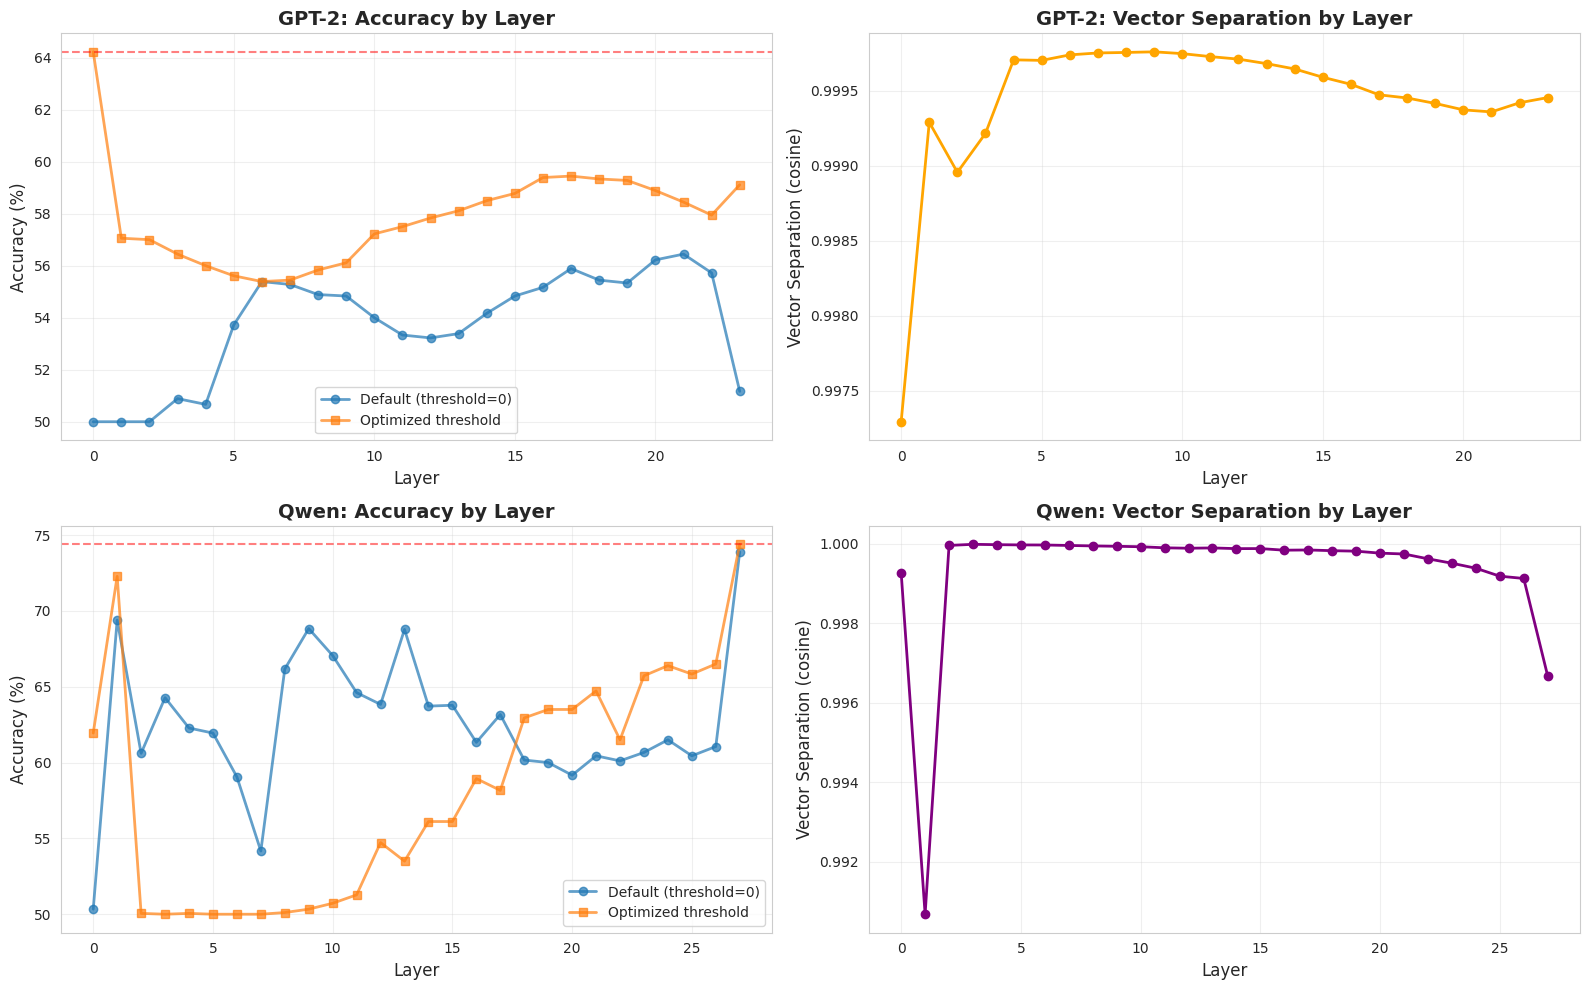


✓ Proper layer analysis complete!


In [16]:
# ============================================================
# 13.COMPREHENSIVE LAYER ANALYSIS - PROPER VERSION
# ============================================================

print("="*60)
print("TESTING ALL LAYERS PROPERLY")
print("="*60)
print("Using FULL 200 training examples")
print("Testing on FULL 1800 test set")
print()

# Cache file
cache_file_proper = '/kaggle/working/all_layers_proper.pkl'

import os
if os.path.exists(cache_file_proper):
    print("Loading cached results...")
    with open(cache_file_proper, 'rb') as f:
        cached = pickle.load(f)
    gpt2_all_layers = cached['gpt2']
    qwen_all_layers = cached['qwen']
    print("✓ Loaded from cache!")
else:
    print("Testing all layers (first time - will take ~1-2 hours)...")
    print("This will be cached for future use!")
    
    # --------------------------------------------------------
    # GPT-2: Test all 24 layers
    # --------------------------------------------------------
    print("\n" + "="*60)
    print("GPT-2: Testing all 24 layers (FULL data)")
    print("="*60)
    
    gpt2_all_layers = {}
    
    for layer_idx in range(24):
        print(f"\n{'='*60}")
        print(f"GPT-2 Layer {layer_idx}/24")
        print(f"{'='*60}")
        
        # Extract weighted vectors with FULL 200 training examples
        safe_vec, danger_vec, sep = extract_weighted_vectors(
            gpt2_model, gpt2_tokenizer,
            safe_train,  # FULL 100 examples
            dangerous_train,  # FULL 100 examples
            layer_idx, batch_size=16
        )
        
        # Test on FULL 1800 test set
        results, acc = test_self_monitoring(
            gpt2_model, gpt2_tokenizer,
            test_queries,  # FULL 1800 examples
            test_labels,
            safe_vec, danger_vec, layer_idx
        )
        
        # Optimize threshold
        thresh_opt, acc_opt = optimize_threshold(results['scores'], test_labels)
        
        gpt2_all_layers[layer_idx] = {
            'results': results,
            'accuracy_default': acc,
            'accuracy_optimized': acc_opt,
            'threshold': thresh_opt,
            'separation': sep,
            'safe_vec': safe_vec,
            'danger_vec': danger_vec
        }
        
        print(f"Layer {layer_idx:2d}: Default {acc*100:5.1f}% → Optimized {acc_opt*100:5.1f}% (thresh: {thresh_opt:.6f})")
    
    # --------------------------------------------------------
    # Qwen: Test all 28 layers
    # --------------------------------------------------------
    print("\n" + "="*60)
    print("QWEN: Testing all 28 layers (FULL data)")
    print("="*60)
    
    qwen_all_layers = {}
    
    for layer_idx in range(28):
        print(f"\n{'='*60}")
        print(f"Qwen Layer {layer_idx}/28")
        print(f"{'='*60}")
        
        # Extract weighted vectors with FULL 200 training examples
        safe_vec, danger_vec, sep = extract_weighted_vectors(
            qwen_model, qwen_tokenizer,
            safe_train,  # FULL 100 examples
            dangerous_train,  # FULL 100 examples
            layer_idx, batch_size=16
        )
        
        # Test on FULL 1800 test set
        results, acc = test_self_monitoring(
            qwen_model, qwen_tokenizer,
            test_queries,  # FULL 1800 examples
            test_labels,
            safe_vec, danger_vec, layer_idx
        )
        
        # Optimize threshold
        thresh_opt, acc_opt = optimize_threshold(results['scores'], test_labels)
        
        qwen_all_layers[layer_idx] = {
            'results': results,
            'accuracy_default': acc,
            'accuracy_optimized': acc_opt,
            'threshold': thresh_opt,
            'separation': sep,
            'safe_vec': safe_vec,
            'danger_vec': danger_vec
        }
        
        print(f"Layer {layer_idx:2d}: Default {acc*100:5.1f}% → Optimized {acc_opt*100:5.1f}% (thresh: {thresh_opt:.6f})")
    
    # Save cache
    print("\n" + "="*60)
    print("SAVING CACHE")
    print("="*60)
    with open(cache_file_proper, 'wb') as f:
        pickle.dump({'gpt2': gpt2_all_layers, 'qwen': qwen_all_layers}, f)
    print("✓ Cached! Next run will be instant!")

# --------------------------------------------------------
# Analysis
# --------------------------------------------------------
print("\n" + "="*60)
print("LAYER PERFORMANCE ANALYSIS")
print("="*60)

# Sort by optimized accuracy
gpt2_sorted = sorted(gpt2_all_layers.items(), key=lambda x: x[1]['accuracy_optimized'], reverse=True)
qwen_sorted = sorted(qwen_all_layers.items(), key=lambda x: x[1]['accuracy_optimized'], reverse=True)

print("\nGPT-2 Top 5 Layers (by optimized accuracy):")
print(f"{'Rank':<6} {'Layer':<8} {'Default':<12} {'Optimized':<12} {'Threshold':<12}")
print("-" * 50)
for i, (layer, data) in enumerate(gpt2_sorted[:5]):
    print(f"{i+1:<6} {layer:<8} {data['accuracy_default']*100:>6.1f}%     {data['accuracy_optimized']*100:>6.1f}%     {data['threshold']:>8.5f}")

print("\nQwen Top 5 Layers (by optimized accuracy):")
print(f"{'Rank':<6} {'Layer':<8} {'Default':<12} {'Optimized':<12} {'Threshold':<12}")
print("-" * 50)
for i, (layer, data) in enumerate(qwen_sorted[:5]):
    print(f"{i+1:<6} {layer:<8} {data['accuracy_default']*100:>6.1f}%     {data['accuracy_optimized']*100:>6.1f}%     {data['threshold']:>8.5f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# GPT-2 accuracy progression
ax = axes[0, 0]
layers = list(range(24))
default_accs = [gpt2_all_layers[l]['accuracy_default']*100 for l in layers]
opt_accs = [gpt2_all_layers[l]['accuracy_optimized']*100 for l in layers]

ax.plot(layers, default_accs, marker='o', linewidth=2, label='Default (threshold=0)', alpha=0.7)
ax.plot(layers, opt_accs, marker='s', linewidth=2, label='Optimized threshold', alpha=0.7)
ax.axhline(y=max(opt_accs), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('GPT-2: Accuracy by Layer', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# GPT-2 separation
ax = axes[0, 1]
seps = [gpt2_all_layers[l]['separation'] for l in layers]
ax.plot(layers, seps, marker='o', linewidth=2, color='orange')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Vector Separation (cosine)', fontsize=12)
ax.set_title('GPT-2: Vector Separation by Layer', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Qwen accuracy progression
ax = axes[1, 0]
layers = list(range(28))
default_accs = [qwen_all_layers[l]['accuracy_default']*100 for l in layers]
opt_accs = [qwen_all_layers[l]['accuracy_optimized']*100 for l in layers]

ax.plot(layers, default_accs, marker='o', linewidth=2, label='Default (threshold=0)', alpha=0.7)
ax.plot(layers, opt_accs, marker='s', linewidth=2, label='Optimized threshold', alpha=0.7)
ax.axhline(y=max(opt_accs), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Qwen: Accuracy by Layer', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Qwen separation
ax = axes[1, 1]
seps = [qwen_all_layers[l]['separation'] for l in layers]
ax.plot(layers, seps, marker='o', linewidth=2, color='purple')
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Vector Separation (cosine)', fontsize=12)
ax.set_title('Qwen: Vector Separation by Layer', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/all_layers_proper.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Proper layer analysis complete!")

In [17]:
# ============================================================
# 14.SMART ENSEMBLE - USE ONLY TOP PERFORMING LAYERS
# ============================================================

print("="*60)
print("SMART ENSEMBLE - TOP LAYERS ONLY")
print("="*60)

# Select top 3 layers for each model
gpt2_top_layers = [layer for layer, data in gpt2_sorted[:3]]
qwen_top_layers = [layer for layer, data in qwen_sorted[:3]]

print(f"\nGPT-2 top layers: {gpt2_top_layers}")
print(f"Qwen top layers: {qwen_top_layers}")

# --------------------------------------------------------
# Extract full vectors for top layers only
# --------------------------------------------------------
print("\n" + "="*60)
print("Extracting vectors for top layers (full training set)...")
print("="*60)

gpt2_top_results = {}
for layer_idx in gpt2_top_layers:
    print(f"\nGPT-2 Layer {layer_idx}...")
    safe_vec, danger_vec, sep = extract_weighted_vectors(
        gpt2_model, gpt2_tokenizer,
        safe_train, dangerous_train,
        layer_idx, batch_size=16
    )
    
    results, acc = test_self_monitoring(
        gpt2_model, gpt2_tokenizer,
        test_queries, test_labels,
        safe_vec, danger_vec, layer_idx
    )
    
    gpt2_top_results[layer_idx] = {
        'results': results,
        'accuracy': acc
    }

qwen_top_results = {}
for layer_idx in qwen_top_layers:
    print(f"\nQwen Layer {layer_idx}...")
    safe_vec, danger_vec, sep = extract_weighted_vectors(
        qwen_model, qwen_tokenizer,
        safe_train, dangerous_train,
        layer_idx, batch_size=16
    )
    
    results, acc = test_self_monitoring(
        qwen_model, qwen_tokenizer,
        test_queries, test_labels,
        safe_vec, danger_vec, layer_idx
    )
    
    qwen_top_results[layer_idx] = {
        'results': results,
        'accuracy': acc
    }

# --------------------------------------------------------
# Smart Ensemble with optimized thresholds
# --------------------------------------------------------
print("\n" + "="*60)
print("SMART ENSEMBLE RESULTS")
print("="*60)

# GPT-2 smart ensemble
gpt2_weights_smart = {l: gpt2_top_results[l]['accuracy'] for l in gpt2_top_layers}
gpt2_smart_scores = weighted_ensemble_with_scores(gpt2_top_results, gpt2_weights_smart)
gpt2_smart_thresh, gpt2_smart_acc = optimize_threshold(gpt2_smart_scores, test_labels)

print(f"\nGPT-2 Smart Ensemble (top {len(gpt2_top_layers)} layers):")
print(f"  Layers: {gpt2_top_layers}")
print(f"  Individual: {[f'{gpt2_top_results[l]["accuracy"]*100:.1f}%' for l in gpt2_top_layers]}")
print(f"  Ensemble: {gpt2_smart_acc*100:.1f}%")
print(f"  vs Best single: {max([gpt2_top_results[l]['accuracy'] for l in gpt2_top_layers])*100:.1f}%")

# Qwen smart ensemble
qwen_weights_smart = {l: qwen_top_results[l]['accuracy'] for l in qwen_top_layers}
qwen_smart_scores = weighted_ensemble_with_scores(qwen_top_results, qwen_weights_smart)
qwen_smart_thresh, qwen_smart_acc = optimize_threshold(qwen_smart_scores, test_labels)

print(f"\nQwen Smart Ensemble (top {len(qwen_top_layers)} layers):")
print(f"  Layers: {qwen_top_layers}")
print(f"  Individual: {[f'{qwen_top_results[l]["accuracy"]*100:.1f}%' for l in qwen_top_layers]}")
print(f"  Ensemble: {qwen_smart_acc*100:.1f}%")
print(f"  vs Best single: {max([qwen_top_results[l]['accuracy'] for l in qwen_top_layers])*100:.1f}%")

# Final metrics
gpt2_smart_metrics = calculate_metrics_optimized(gpt2_smart_scores, test_labels, gpt2_smart_thresh)
qwen_smart_metrics = calculate_metrics_optimized(qwen_smart_scores, test_labels, qwen_smart_thresh)

print("\n" + "="*60)
print("FINAL SMART ENSEMBLE F1 SCORES")
print("="*60)
print(f"GPT-2: {gpt2_smart_metrics['weighted_f1']*100:.1f}% F1")
print(f"Qwen:  {qwen_smart_metrics['weighted_f1']*100:.1f}% F1")

print("\n✓ Smart ensemble complete!")

SMART ENSEMBLE - TOP LAYERS ONLY

GPT-2 top layers: [0, 17, 16]
Qwen top layers: [27, 1, 26]

Extracting vectors for top layers (full training set)...

GPT-2 Layer 0...

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.77it/s]


  Unweighted mean norm: 2.2223
  Weighted mean norm: 2.2474
  Weight distribution: min=0.002705, max=0.011458, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00, 10.92it/s]


  Unweighted mean norm: 2.1760
  Weighted mean norm: 2.1898
  Weight distribution: min=0.006933, max=0.011465, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9973


Testing Layer 0: 100%|██████████| 1800/1800 [00:32<00:00, 55.32it/s]



GPT-2 Layer 17...

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


  Unweighted mean norm: 479.7344
  Weighted mean norm: 484.9492
  Weight distribution: min=0.006597, max=0.010401, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00, 10.27it/s]


  Unweighted mean norm: 455.3766
  Weighted mean norm: 459.2724
  Weight distribution: min=0.008535, max=0.010394, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 17: 100%|██████████| 1800/1800 [00:32<00:00, 55.75it/s]



GPT-2 Layer 16...

Extracting WEIGHTED vectors from Layer 16...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.94it/s]


  Unweighted mean norm: 462.9940
  Weighted mean norm: 467.6555
  Weight distribution: min=0.006560, max=0.010364, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.74it/s]


  Unweighted mean norm: 438.3589
  Weighted mean norm: 441.8206
  Weight distribution: min=0.008776, max=0.010356, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 16: 100%|██████████| 1800/1800 [00:32<00:00, 55.71it/s]



Qwen Layer 27...

Extracting WEIGHTED vectors from Layer 27...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


  Unweighted mean norm: 245.9237
  Weighted mean norm: 246.4244
  Weight distribution: min=0.006759, max=0.011142, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


  Unweighted mean norm: 246.6057
  Weighted mean norm: 247.0174
  Weight distribution: min=0.008288, max=0.010940, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9967


Testing Layer 27: 100%|██████████| 1800/1800 [01:30<00:00, 19.93it/s]



Qwen Layer 1...

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


  Unweighted mean norm: 7.3408
  Weighted mean norm: 7.3535
  Weight distribution: min=0.001583, max=0.014253, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


  Unweighted mean norm: 7.2500
  Weighted mean norm: 7.2615
  Weight distribution: min=0.003312, max=0.013243, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9907


Testing Layer 1: 100%|██████████| 1800/1800 [01:32<00:00, 19.40it/s]



Qwen Layer 26...

Extracting WEIGHTED vectors from Layer 26...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


  Unweighted mean norm: 456.4681
  Weighted mean norm: 457.4355
  Weight distribution: min=0.008326, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


  Unweighted mean norm: 456.8155
  Weighted mean norm: 456.8726
  Weight distribution: min=0.009634, max=0.010205, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9991


Testing Layer 26: 100%|██████████| 1800/1800 [01:33<00:00, 19.35it/s]


SMART ENSEMBLE RESULTS

GPT-2 Smart Ensemble (top 3 layers):
  Layers: [0, 17, 16]
  Individual: ['50.0%', '55.9%', '55.2%']
  Ensemble: 61.3%
  vs Best single: 55.9%

Qwen Smart Ensemble (top 3 layers):
  Layers: [27, 1, 26]
  Individual: ['73.9%', '69.4%', '61.1%']
  Ensemble: 73.8%
  vs Best single: 73.9%

FINAL SMART ENSEMBLE F1 SCORES
GPT-2: 60.8% F1
Qwen:  73.8% F1

✓ Smart ensemble complete!


STABILITY TEST - PROPERLY SHUFFLED

Verifying split balance:
Split 1: 290 safe, 310 dangerous
Split 2: 313 safe, 287 dangerous
Split 3: 297 safe, 303 dangerous

GPT-2 STABILITY TEST

Training size: 50 examples (Test split 1)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


  Unweighted mean norm: 2.3021
  Weighted mean norm: 2.3257
  Weight distribution: min=0.021958, max=0.043950, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


  Unweighted mean norm: 2.1482
  Weighted mean norm: 2.1532
  Weight distribution: min=0.032451, max=0.046129, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9842


Testing Layer 0: 100%|██████████| 600/600 [00:10<00:00, 55.39it/s]


  Layer  0:  52.7% (thresh: -0.04648)

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00, 12.61it/s]


  Unweighted mean norm: 514.6769
  Weighted mean norm: 518.1164
  Weight distribution: min=0.032907, max=0.040993, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


  Unweighted mean norm: 440.1623
  Weighted mean norm: 443.4226
  Weight distribution: min=0.035481, max=0.041577, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9977


Testing Layer 17: 100%|██████████| 600/600 [00:10<00:00, 55.85it/s]


  Layer 17:  55.8% (thresh: -0.00327)

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


  Unweighted mean norm: 540.3560
  Weighted mean norm: 544.1542
  Weight distribution: min=0.032764, max=0.041056, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


  Unweighted mean norm: 463.6871
  Weighted mean norm: 467.3744
  Weight distribution: min=0.035191, max=0.041705, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9975


Testing Layer 18: 100%|██████████| 600/600 [00:10<00:00, 56.15it/s]


  Layer 18:  55.5% (thresh: -0.00477)

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00, 12.43it/s]


  Unweighted mean norm: 890.9320
  Weighted mean norm: 892.7844
  Weight distribution: min=0.034830, max=0.040824, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


  Unweighted mean norm: 839.8582
  Weighted mean norm: 841.2277
  Weight distribution: min=0.037505, max=0.041210, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9969


Testing Layer 23: 100%|██████████| 600/600 [00:10<00:00, 55.96it/s]


  Layer 23:  54.3% (thresh: -0.01281)

Training size: 100 examples (Test split 2)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 4/4 [00:00<00:00, 11.31it/s]


  Unweighted mean norm: 2.2299
  Weighted mean norm: 2.2527
  Weight distribution: min=0.012242, max=0.022649, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:00<00:00, 11.12it/s]


  Unweighted mean norm: 2.1560
  Weighted mean norm: 2.1649
  Weight distribution: min=0.015111, max=0.022877, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9935


Testing Layer 0: 100%|██████████| 600/600 [00:10<00:00, 56.24it/s]


  Layer  0:  63.2% (thresh: -0.04296)

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 4/4 [00:00<00:00, 11.04it/s]


  Unweighted mean norm: 482.9268
  Weighted mean norm: 487.4760
  Weight distribution: min=0.016560, max=0.020702, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


  Unweighted mean norm: 443.2429
  Weighted mean norm: 446.8172
  Weight distribution: min=0.017309, max=0.020798, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9991


Testing Layer 17: 100%|██████████| 600/600 [00:10<00:00, 55.44it/s]


  Layer 17:  58.7% (thresh: -0.00678)

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


  Unweighted mean norm: 508.2724
  Weighted mean norm: 513.3978
  Weight distribution: min=0.016016, max=0.020758, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:00<00:00, 10.89it/s]


  Unweighted mean norm: 466.5758
  Weighted mean norm: 470.6079
  Weight distribution: min=0.017181, max=0.020861, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9990


Testing Layer 18: 100%|██████████| 600/600 [00:10<00:00, 55.38it/s]


  Layer 18:  58.5% (thresh: -0.00779)

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


  Unweighted mean norm: 870.1866
  Weighted mean norm: 872.8872
  Weight distribution: min=0.016572, max=0.020559, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:00<00:00, 10.50it/s]


  Unweighted mean norm: 836.9780
  Weighted mean norm: 838.7464
  Weight distribution: min=0.018146, max=0.020640, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9990


Testing Layer 23: 100%|██████████| 600/600 [00:10<00:00, 55.97it/s]


  Layer 23:  56.8% (thresh: -0.00678)

Training size: 200 examples (Test split 3)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


  Unweighted mean norm: 2.2223
  Weighted mean norm: 2.2474
  Weight distribution: min=0.002705, max=0.011458, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.44it/s]


  Unweighted mean norm: 2.1760
  Weighted mean norm: 2.1898
  Weight distribution: min=0.006933, max=0.011465, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9973


Testing Layer 0: 100%|██████████| 600/600 [00:10<00:00, 55.89it/s]


  Layer  0:  64.3% (thresh: -0.02588)

Extracting WEIGHTED vectors from Layer 17...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


  Unweighted mean norm: 479.7344
  Weighted mean norm: 484.9492
  Weight distribution: min=0.006597, max=0.010401, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


  Unweighted mean norm: 455.3766
  Weighted mean norm: 459.2724
  Weight distribution: min=0.008535, max=0.010394, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 17: 100%|██████████| 600/600 [00:10<00:00, 56.09it/s]


  Layer 17:  60.8% (thresh: -0.00126)

Extracting WEIGHTED vectors from Layer 18...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


  Unweighted mean norm: 504.5981
  Weighted mean norm: 510.4241
  Weight distribution: min=0.006599, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.26it/s]


  Unweighted mean norm: 479.1107
  Weighted mean norm: 483.4787
  Weight distribution: min=0.008465, max=0.010424, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 18: 100%|██████████| 600/600 [00:10<00:00, 56.21it/s]


  Layer 18:  61.2% (thresh: -0.00126)

Extracting WEIGHTED vectors from Layer 23...
Processing safe examples...


100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


  Unweighted mean norm: 862.5554
  Weighted mean norm: 865.9949
  Weight distribution: min=0.007112, max=0.010333, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


  Unweighted mean norm: 846.0099
  Weighted mean norm: 848.0958
  Weight distribution: min=0.008971, max=0.010324, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9995


Testing Layer 23: 100%|██████████| 600/600 [00:10<00:00, 55.25it/s]


  Layer 23:  59.3% (thresh: -0.00327)

QWEN STABILITY TEST

Training size: 50 examples (Test split 1)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


  Unweighted mean norm: 0.5971
  Weighted mean norm: 0.6914
  Weight distribution: min=0.001391, max=0.051866, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


  Unweighted mean norm: 0.5000
  Weighted mean norm: 0.6075
  Weight distribution: min=0.004291, max=0.058788, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9950


Testing Layer 0: 100%|██████████| 600/600 [00:30<00:00, 19.63it/s]


  Layer  0:  52.5% (thresh: -0.04749)

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


  Unweighted mean norm: 7.4468
  Weighted mean norm: 7.4643
  Weight distribution: min=0.025296, max=0.054459, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


  Unweighted mean norm: 7.2801
  Weighted mean norm: 7.2622
  Weight distribution: min=0.022188, max=0.049736, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9704


Testing Layer 1: 100%|██████████| 600/600 [00:30<00:00, 19.53it/s]


  Layer  1:  60.0% (thresh: -0.00126)

Extracting WEIGHTED vectors from Layer 26...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


  Unweighted mean norm: 527.9834
  Weighted mean norm: 528.4310
  Weight distribution: min=0.038501, max=0.040885, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


  Unweighted mean norm: 448.9756
  Weighted mean norm: 449.0526
  Weight distribution: min=0.038785, max=0.040783, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9954


Testing Layer 26: 100%|██████████| 600/600 [00:30<00:00, 19.47it/s]


  Layer 26:  55.5% (thresh: +0.00930)

Extracting WEIGHTED vectors from Layer 27...
Processing safe examples...


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


  Unweighted mean norm: 241.9764
  Weighted mean norm: 242.4694
  Weight distribution: min=0.033549, max=0.044578, mean=0.040000
Processing dangerous examples...


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


  Unweighted mean norm: 250.0992
  Weighted mean norm: 250.5739
  Weight distribution: min=0.036376, max=0.043053, mean=0.040000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9939


Testing Layer 27: 100%|██████████| 600/600 [00:31<00:00, 19.30it/s]


  Layer 27:  66.8% (thresh: -0.00176)

Training size: 100 examples (Test split 2)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


  Unweighted mean norm: 0.5769
  Weighted mean norm: 0.6751
  Weight distribution: min=0.000790, max=0.026549, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


  Unweighted mean norm: 0.5007
  Weighted mean norm: 0.6073
  Weight distribution: min=0.001477, max=0.028691, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9983


Testing Layer 0: 100%|██████████| 600/600 [00:30<00:00, 19.36it/s]


  Layer  0:  58.3% (thresh: -0.02990)

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


  Unweighted mean norm: 7.3531
  Weighted mean norm: 7.3496
  Weight distribution: min=0.010503, max=0.027634, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


  Unweighted mean norm: 7.2480
  Weighted mean norm: 7.2458
  Weight distribution: min=0.006616, max=0.024788, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9884


Testing Layer 1: 100%|██████████| 600/600 [00:30<00:00, 19.40it/s]


  Layer  1:  70.2% (thresh: -0.00427)

Extracting WEIGHTED vectors from Layer 26...
Processing safe examples...


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


  Unweighted mean norm: 468.7610
  Weighted mean norm: 468.8310
  Weight distribution: min=0.019265, max=0.020581, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


  Unweighted mean norm: 453.8831
  Weighted mean norm: 453.9337
  Weight distribution: min=0.019275, max=0.020427, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9989


Testing Layer 26: 100%|██████████| 600/600 [00:31<00:00, 19.30it/s]


  Layer 26:  59.8% (thresh: -0.00075)

Extracting WEIGHTED vectors from Layer 27...
Processing safe examples...


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


  Unweighted mean norm: 245.4556
  Weighted mean norm: 246.0469
  Weight distribution: min=0.016207, max=0.022189, mean=0.020000
Processing dangerous examples...


100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


  Unweighted mean norm: 247.8992
  Weighted mean norm: 248.2882
  Weight distribution: min=0.017315, max=0.021819, mean=0.020000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9967


Testing Layer 27: 100%|██████████| 600/600 [00:31<00:00, 19.24it/s]


  Layer 27:  74.2% (thresh: -0.00126)

Training size: 200 examples (Test split 3)

Extracting WEIGHTED vectors from Layer 0...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 0.5960
  Weighted mean norm: 0.6975
  Weight distribution: min=0.000381, max=0.013287, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


  Unweighted mean norm: 0.5162
  Weighted mean norm: 0.6358
  Weight distribution: min=0.000290, max=0.014189, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9993


Testing Layer 0: 100%|██████████| 600/600 [00:31<00:00, 19.30it/s]


  Layer  0:  62.2% (thresh: -0.01080)

Extracting WEIGHTED vectors from Layer 1...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 7.3408
  Weighted mean norm: 7.3535
  Weight distribution: min=0.001583, max=0.014253, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 7.2500
  Weighted mean norm: 7.2615
  Weight distribution: min=0.003312, max=0.013243, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9907


Testing Layer 1: 100%|██████████| 600/600 [00:31<00:00, 19.22it/s]


  Layer  1:  72.5% (thresh: -0.00729)

Extracting WEIGHTED vectors from Layer 26...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


  Unweighted mean norm: 456.4681
  Weighted mean norm: 457.4355
  Weight distribution: min=0.008326, max=0.010434, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


  Unweighted mean norm: 456.8155
  Weighted mean norm: 456.8726
  Weight distribution: min=0.009634, max=0.010205, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9991


Testing Layer 26: 100%|██████████| 600/600 [00:31<00:00, 19.30it/s]


  Layer 26:  68.0% (thresh: +0.00126)

Extracting WEIGHTED vectors from Layer 27...
Processing safe examples...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


  Unweighted mean norm: 245.9237
  Weighted mean norm: 246.4244
  Weight distribution: min=0.006759, max=0.011142, mean=0.010000
Processing dangerous examples...


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


  Unweighted mean norm: 246.6057
  Weighted mean norm: 247.0174
  Weight distribution: min=0.008288, max=0.010940, mean=0.010000

✓ Weighted extraction complete!
  Vector separation (cosine): 0.9967


Testing Layer 27: 100%|██████████| 600/600 [00:31<00:00, 19.17it/s]


  Layer 27:  74.0% (thresh: -0.00075)

STABILITY SUMMARY

GPT-2 Layer Stability:
Layer    50→100→200           Trend    Variance  
--------------------------------------------------
0        52.7→63.2→64.3       ↑ Improving    0.0028
17       55.8→58.7→60.8       → Stable    0.0004
18       55.5→58.5→61.2       ↑ Improving    0.0005
23       54.3→56.8→59.3       → Stable    0.0004

Qwen Layer Stability:
Layer    50→100→200           Trend    Variance  
--------------------------------------------------
0        52.5→58.3→62.2       ↑ Improving    0.0016
1        60.0→70.2→72.5       ↑ Improving    0.0029
26       55.5→59.8→68.0       ↑ Improving    0.0027
27       66.8→74.2→74.0       ↑ Improving    0.0012


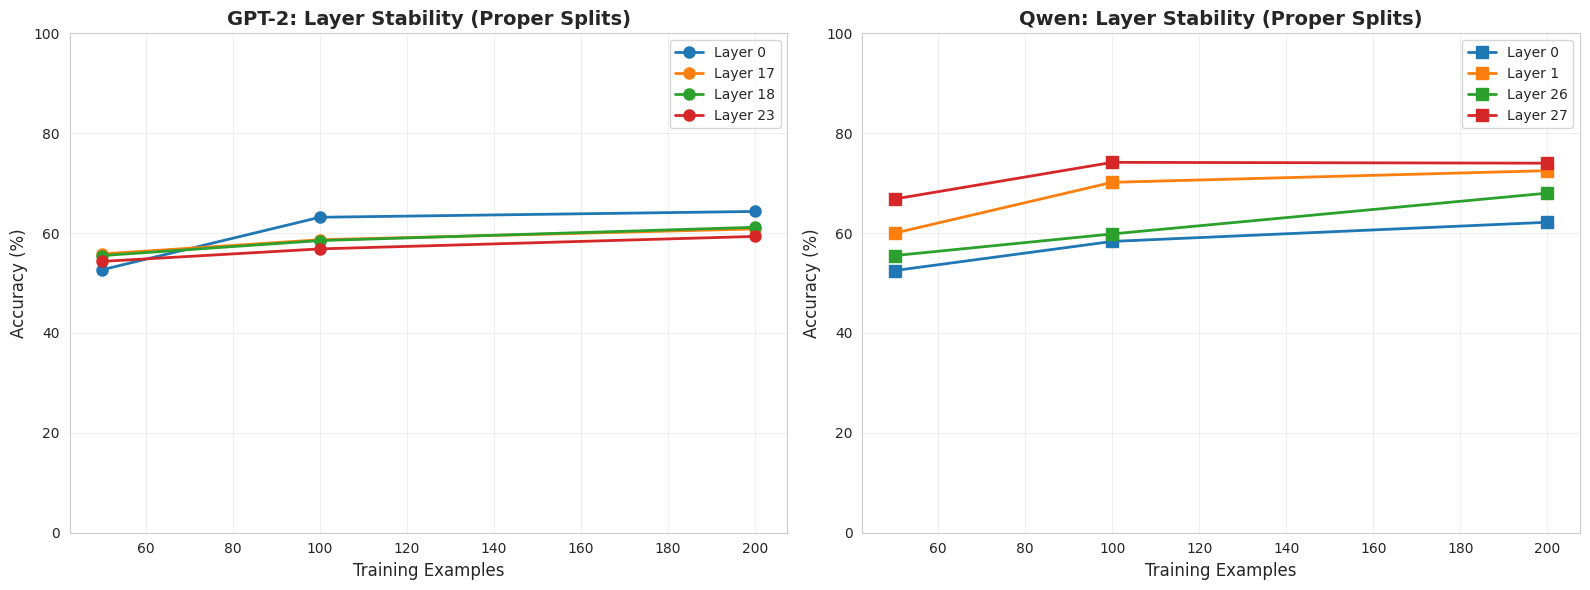


✓ Proper stability test complete!


In [23]:
# ============================================================
# 15. PROPER STABILITY TEST (SHUFFLED SPLITS)
# ============================================================

print("="*60)
print("STABILITY TEST - PROPERLY SHUFFLED")
print("="*60)

# CRITICAL: Shuffle test set before splitting!
import random

# Create shuffled indices
all_indices = list(range(len(test_queries)))
random.seed(42)
random.shuffle(all_indices)

# Create 3 non-overlapping splits of 600 each
split_size = 600
split_1_idx = all_indices[0:split_size]
split_2_idx = all_indices[split_size:split_size*2]
split_3_idx = all_indices[split_size*2:split_size*3]

# Create splits
test_split_1 = ([test_queries[i] for i in split_1_idx], 
                [test_labels[i] for i in split_1_idx])
test_split_2 = ([test_queries[i] for i in split_2_idx], 
                [test_labels[i] for i in split_2_idx])
test_split_3 = ([test_queries[i] for i in split_3_idx], 
                [test_labels[i] for i in split_3_idx])

# Verify balance
print("\nVerifying split balance:")
for i, (queries, labels) in enumerate([test_split_1, test_split_2, test_split_3], 1):
    safe_count = sum(1 for l in labels if l == 0)
    danger_count = sum(1 for l in labels if l == 1)
    print(f"Split {i}: {safe_count} safe, {danger_count} dangerous")

test_splits = [test_split_1, test_split_2, test_split_3]

dataset_sizes = [50, 100, 200]
test_layers_gpt2 = [0, 17, 18, 23]
test_layers_qwen = [0, 1, 26, 27]

stability_results = {'gpt2': {}, 'qwen': {}}

# ============================================================
# GPT-2 Stability
# ============================================================
print("\n" + "="*60)
print("GPT-2 STABILITY TEST")
print("="*60)

for i, n in enumerate(dataset_sizes):
    print(f"\nTraining size: {n} examples (Test split {i+1})")
    
    safe_sample = safe_train[:n//2]
    dangerous_sample = dangerous_train[:n//2]
    
    test_queries_split, test_labels_split = test_splits[i]
    
    stability_results['gpt2'][n] = {}
    
    for layer in test_layers_gpt2:
        # Extract vectors
        safe_vec, danger_vec, sep = extract_weighted_vectors(
            gpt2_model, gpt2_tokenizer,
            safe_sample, dangerous_sample,
            layer, batch_size=16
        )
        
        # Test
        results, acc = test_self_monitoring(
            gpt2_model, gpt2_tokenizer,
            test_queries_split, test_labels_split,
            safe_vec, danger_vec, layer
        )
        
        # Optimize threshold
        thresh, acc_opt = optimize_threshold(results['scores'], test_labels_split)
        
        stability_results['gpt2'][n][layer] = {
            'accuracy': acc_opt,
            'separation': sep,
            'threshold': thresh
        }
        
        print(f"  Layer {layer:2d}: {acc_opt*100:5.1f}% (thresh: {thresh:+.5f})")

# ============================================================
# Qwen Stability
# ============================================================
print("\n" + "="*60)
print("QWEN STABILITY TEST")
print("="*60)

for i, n in enumerate(dataset_sizes):
    print(f"\nTraining size: {n} examples (Test split {i+1})")
    
    safe_sample = safe_train[:n//2]
    dangerous_sample = dangerous_train[:n//2]
    
    test_queries_split, test_labels_split = test_splits[i]
    
    stability_results['qwen'][n] = {}
    
    for layer in test_layers_qwen:
        safe_vec, danger_vec, sep = extract_weighted_vectors(
            qwen_model, qwen_tokenizer,
            safe_sample, dangerous_sample,
            layer, batch_size=16
        )
        
        results, acc = test_self_monitoring(
            qwen_model, qwen_tokenizer,
            test_queries_split, test_labels_split,
            safe_vec, danger_vec, layer
        )
        
        thresh, acc_opt = optimize_threshold(results['scores'], test_labels_split)
        
        stability_results['qwen'][n][layer] = {
            'accuracy': acc_opt,
            'separation': sep,
            'threshold': thresh
        }
        
        print(f"  Layer {layer:2d}: {acc_opt*100:5.1f}% (thresh: {thresh:+.5f})")

# ============================================================
# Analysis
# ============================================================
print("\n" + "="*60)
print("STABILITY SUMMARY")
print("="*60)

print("\nGPT-2 Layer Stability:")
print(f"{'Layer':<8} {'50→100→200':<20} {'Trend':<8} {'Variance':<10}")
print("-" * 50)
for layer in test_layers_gpt2:
    accs = [stability_results['gpt2'][n][layer]['accuracy'] for n in dataset_sizes]
    variance = np.var(accs)
    
    if accs[2] > accs[0] + 0.05:
        trend = "↑ Improving"
    elif accs[2] < accs[0] - 0.05:
        trend = "↓ Declining"
    else:
        trend = "→ Stable"
    
    acc_str = f"{accs[0]*100:4.1f}→{accs[1]*100:4.1f}→{accs[2]*100:4.1f}"
    print(f"{layer:<8} {acc_str:<20} {trend:<8} {variance:>9.4f}")

print("\nQwen Layer Stability:")
print(f"{'Layer':<8} {'50→100→200':<20} {'Trend':<8} {'Variance':<10}")
print("-" * 50)
for layer in test_layers_qwen:
    accs = [stability_results['qwen'][n][layer]['accuracy'] for n in dataset_sizes]
    variance = np.var(accs)
    
    if accs[2] > accs[0] + 0.05:
        trend = "↑ Improving"
    elif accs[2] < accs[0] - 0.05:
        trend = "↓ Declining"
    else:
        trend = "→ Stable"
    
    acc_str = f"{accs[0]*100:4.1f}→{accs[1]*100:4.1f}→{accs[2]*100:4.1f}"
    print(f"{layer:<8} {acc_str:<20} {trend:<8} {variance:>9.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# GPT-2
ax = axes[0]
for layer in test_layers_gpt2:
    accs = [stability_results['gpt2'][n][layer]['accuracy']*100 for n in dataset_sizes]
    ax.plot(dataset_sizes, accs, marker='o', label=f'Layer {layer}', linewidth=2, markersize=8)

ax.set_xlabel('Training Examples', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('GPT-2: Layer Stability (Proper Splits)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim([0, 100])

# Qwen
ax = axes[1]
for layer in test_layers_qwen:
    accs = [stability_results['qwen'][n][layer]['accuracy']*100 for n in dataset_sizes]
    ax.plot(dataset_sizes, accs, marker='s', label=f'Layer {layer}', linewidth=2, markersize=8)

ax.set_xlabel('Training Examples', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Qwen: Layer Stability (Proper Splits)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim([0, 100])

plt.tight_layout()
plt.savefig('/kaggle/working/stability_proper.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Proper stability test complete!")
 

STEERING VECTORS - SINGLE DIRECTION METHOD

Concept: Instead of two separate vectors (safe + dangerous),
use ONE steering vector = direction from dangerous → safe


GPT-2 STEERING VECTOR (Layer 18 - best from stability test)
Extracting steering vector from Layer 18...


Dangerous examples: 100%|██████████| 7/7 [00:00<00:00, 10.79it/s]



✓ Steering vector extracted!
  Vector norm: 30.401842
  Magnitude: 30.401842


Testing Layer 18: 100%|██████████| 1800/1800 [00:33<00:00, 53.49it/s]



GPT-2 Steering Vector Results:
  Default (threshold=0): 50.0%
  Optimized (threshold=-0.050000): 50.0%

QWEN STEERING VECTOR (Layer 27 - best from stability test)
Extracting steering vector from Layer 27...


Dangerous examples: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]



✓ Steering vector extracted!
  Vector norm: 20.212355
  Magnitude: 20.212355


Testing Layer 27: 100%|██████████| 1800/1800 [01:28<00:00, 20.45it/s]



Qwen Steering Vector Results:
  Default (threshold=0): 68.8%
  Optimized (threshold=-0.050000): 68.9%

COMPARISON: TWO-VECTOR vs STEERING APPROACH
Model  Two Vectors (Original)  Steering Vector (New)  Improvement
GPT-2                    61.2              50.000000   -11.200000
 Qwen                    74.0              68.888889    -5.111111

DETAILED METRICS - STEERING VECTORS

GPT-2 (Layer 18, Steering Vector):
Class           Precision    Recall       F1-Score    
---------------------------------------------------
Safe            0.500        1.000        0.667       
Dangerous       0.000        0.000        0.000       
Weighted F1     0.333

Qwen (Layer 27, Steering Vector):
Class           Precision    Recall       F1-Score    
---------------------------------------------------
Safe            0.812        0.491        0.612       
Dangerous       0.635        0.887        0.740       
Weighted F1     0.676


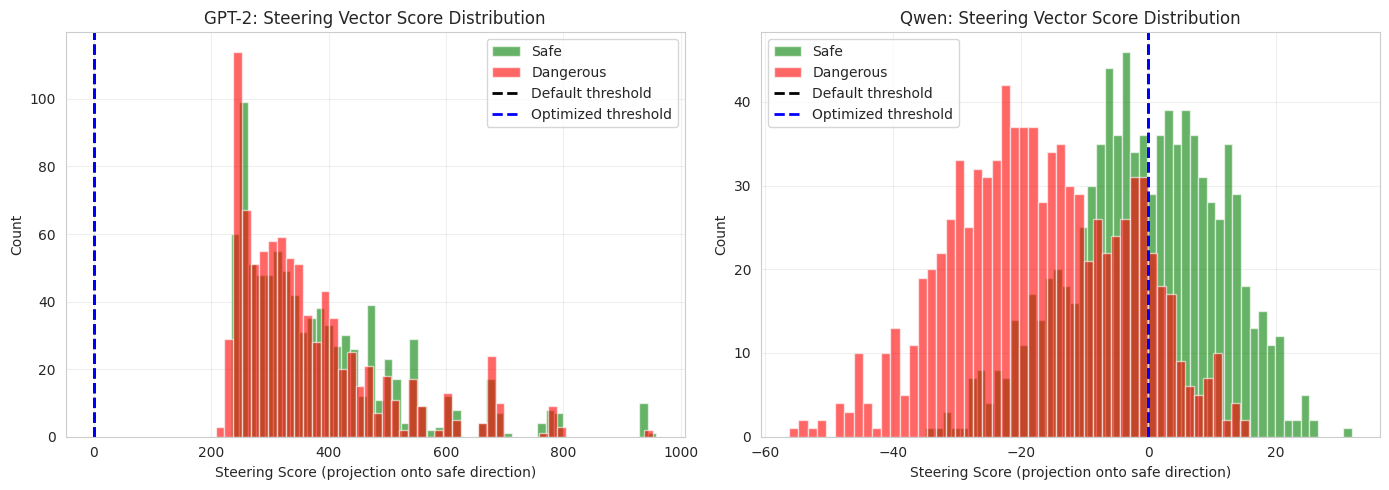


✓ Steering vector analysis complete!

Key Findings:
  GPT-2: 61.2% → 50.0% (-11.2%)
  Qwen:  74.0% → 68.9% (-5.1%)


In [24]:
# ============================================================
# 16. METHOD A: STEERING VECTORS (DIFFERENCE APPROACH)
# ============================================================

print("="*60)
print("STEERING VECTORS - SINGLE DIRECTION METHOD")
print("="*60)

print("\nConcept: Instead of two separate vectors (safe + dangerous),")
print("use ONE steering vector = direction from dangerous → safe")
print()

# ============================================================
# Extract Steering Vectors
# ============================================================

def extract_steering_vector(model, tokenizer, safe_examples, dangerous_examples, layer_idx, batch_size=16):
    """
    Extract a single steering vector (safe - dangerous direction)
    """
    print(f"Extracting steering vector from Layer {layer_idx}...")
    
    # Get activations for safe examples
    safe_activations = []
    for i in tqdm(range(0, len(safe_examples), batch_size), desc="Safe examples"):
        batch = safe_examples[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
            safe_activations.append(activation)
    
    safe_activations = torch.cat(safe_activations, dim=0)
    
    # Get activations for dangerous examples
    dangerous_activations = []
    for i in tqdm(range(0, len(dangerous_examples), batch_size), desc="Dangerous examples"):
        batch = dangerous_examples[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
            dangerous_activations.append(activation)
    
    dangerous_activations = torch.cat(dangerous_activations, dim=0)
    
    # Calculate mean vectors
    safe_mean = safe_activations.mean(dim=0, keepdim=True)
    dangerous_mean = dangerous_activations.mean(dim=0, keepdim=True)
    
    # STEERING VECTOR = direction from dangerous to safe
    steering_vector = safe_mean - dangerous_mean
    
    # Normalize
    steering_vector_normalized = steering_vector / steering_vector.norm()
    
    # Calculate magnitude (how strong is the difference?)
    magnitude = (safe_mean - dangerous_mean).norm().item()
    
    print(f"\n✓ Steering vector extracted!")
    print(f"  Vector norm: {steering_vector.norm().item():.6f}")
    print(f"  Magnitude: {magnitude:.6f}")
    
    return steering_vector_normalized, magnitude

# ============================================================
# Test Function for Steering Vectors
# ============================================================

def test_steering_vector(model, tokenizer, queries, labels, steering_vec, layer_idx):
    """
    Test using steering vector approach
    Score = how much query aligns with safe direction
    """
    results = {
        'queries': [],
        'true_labels': [],
        'predictions': [],
        'scores': [],
        'correct': []
    }
    
    for query, label in tqdm(zip(queries, labels), total=len(queries), desc=f"Testing Layer {layer_idx}"):
        # Get query activation
        with torch.no_grad():
            inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        # Score = projection onto steering direction
        # Positive = aligned with safe direction
        # Negative = aligned with dangerous direction
        score = torch.dot(activation.squeeze(), steering_vec.squeeze()).item()
        
        # Prediction: positive score = safe, negative = dangerous
        prediction = 0 if score > 0 else 1
        
        results['queries'].append(query)
        results['true_labels'].append(label)
        results['predictions'].append(prediction)
        results['scores'].append(score)
        results['correct'].append(prediction == label)
    
    accuracy = sum(results['correct']) / len(results['correct'])
    
    return results, accuracy

# ============================================================
# Extract and Test - GPT-2
# ============================================================

print("\n" + "="*60)
print("GPT-2 STEERING VECTOR (Layer 18 - best from stability test)")
print("="*60)

gpt2_steering_vec, gpt2_magnitude = extract_steering_vector(
    gpt2_model, gpt2_tokenizer,
    safe_train, dangerous_train,
    layer_idx=18,  # Using best layer from stability test
    batch_size=16
)

# Test on full test set
gpt2_steering_results, gpt2_steering_acc = test_steering_vector(
    gpt2_model, gpt2_tokenizer,
    test_queries, test_labels,
    gpt2_steering_vec,
    layer_idx=18
)

print(f"\nGPT-2 Steering Vector Results:")
print(f"  Default (threshold=0): {gpt2_steering_acc*100:.1f}%")

# Optimize threshold
gpt2_steering_thresh, gpt2_steering_acc_opt = optimize_threshold(
    gpt2_steering_results['scores'], 
    test_labels
)

print(f"  Optimized (threshold={gpt2_steering_thresh:.6f}): {gpt2_steering_acc_opt*100:.1f}%")

# ============================================================
# Extract and Test - Qwen
# ============================================================

print("\n" + "="*60)
print("QWEN STEERING VECTOR (Layer 27 - best from stability test)")
print("="*60)

qwen_steering_vec, qwen_magnitude = extract_steering_vector(
    qwen_model, qwen_tokenizer,
    safe_train, dangerous_train,
    layer_idx=27,
    batch_size=16
)

# Test on full test set
qwen_steering_results, qwen_steering_acc = test_steering_vector(
    qwen_model, qwen_tokenizer,
    test_queries, test_labels,
    qwen_steering_vec,
    layer_idx=27
)

print(f"\nQwen Steering Vector Results:")
print(f"  Default (threshold=0): {qwen_steering_acc*100:.1f}%")

# Optimize threshold
qwen_steering_thresh, qwen_steering_acc_opt = optimize_threshold(
    qwen_steering_results['scores'], 
    test_labels
)

print(f"  Optimized (threshold={qwen_steering_thresh:.6f}): {qwen_steering_acc_opt*100:.1f}%")

# ============================================================
# Comparison: Two Vectors vs Steering Vector
# ============================================================

print("\n" + "="*60)
print("COMPARISON: TWO-VECTOR vs STEERING APPROACH")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['GPT-2', 'Qwen'],
    'Two Vectors (Original)': [
        61.2,  # From stability test
        74.0
    ],
    'Steering Vector (New)': [
        gpt2_steering_acc_opt * 100,
        qwen_steering_acc_opt * 100
    ],
    'Improvement': [
        (gpt2_steering_acc_opt * 100) - 61.2,
        (qwen_steering_acc_opt * 100) - 74.0
    ]
})

print(comparison_df.to_string(index=False))

# Calculate metrics for steering approach
gpt2_steering_metrics = calculate_metrics_optimized(
    gpt2_steering_results['scores'],
    test_labels,
    gpt2_steering_thresh
)

qwen_steering_metrics = calculate_metrics_optimized(
    qwen_steering_results['scores'],
    test_labels,
    qwen_steering_thresh
)

print("\n" + "="*60)
print("DETAILED METRICS - STEERING VECTORS")
print("="*60)

print("\nGPT-2 (Layer 18, Steering Vector):")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {gpt2_steering_metrics['safe']['precision']:<12.3f} {gpt2_steering_metrics['safe']['recall']:<12.3f} {gpt2_steering_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {gpt2_steering_metrics['dangerous']['precision']:<12.3f} {gpt2_steering_metrics['dangerous']['recall']:<12.3f} {gpt2_steering_metrics['dangerous']['f1']:<12.3f}")
print(f"{'Weighted F1':<15} {gpt2_steering_metrics['weighted_f1']:.3f}")

print("\nQwen (Layer 27, Steering Vector):")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {qwen_steering_metrics['safe']['precision']:<12.3f} {qwen_steering_metrics['safe']['recall']:<12.3f} {qwen_steering_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {qwen_steering_metrics['dangerous']['precision']:<12.3f} {qwen_steering_metrics['dangerous']['recall']:<12.3f} {qwen_steering_metrics['dangerous']['f1']:<12.3f}")
print(f"{'Weighted F1':<15} {qwen_steering_metrics['weighted_f1']:.3f}")

# Visualize score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GPT-2
ax = axes[0]
gpt2_scores = np.array(gpt2_steering_results['scores'])
gpt2_labels_arr = np.array(gpt2_steering_results['true_labels'])

ax.hist(gpt2_scores[gpt2_labels_arr == 0], bins=50, alpha=0.6, label='Safe', color='green')
ax.hist(gpt2_scores[gpt2_labels_arr == 1], bins=50, alpha=0.6, label='Dangerous', color='red')
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Default threshold')
ax.axvline(gpt2_steering_thresh, color='blue', linestyle='--', linewidth=2, label='Optimized threshold')
ax.set_xlabel('Steering Score (projection onto safe direction)')
ax.set_ylabel('Count')
ax.set_title('GPT-2: Steering Vector Score Distribution')
ax.legend()
ax.grid(alpha=0.3)

# Qwen
ax = axes[1]
qwen_scores = np.array(qwen_steering_results['scores'])
qwen_labels_arr = np.array(qwen_steering_results['true_labels'])

ax.hist(qwen_scores[qwen_labels_arr == 0], bins=50, alpha=0.6, label='Safe', color='green')
ax.hist(qwen_scores[qwen_labels_arr == 1], bins=50, alpha=0.6, label='Dangerous', color='red')
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Default threshold')
ax.axvline(qwen_steering_thresh, color='blue', linestyle='--', linewidth=2, label='Optimized threshold')
ax.set_xlabel('Steering Score (projection onto safe direction)')
ax.set_ylabel('Count')
ax.set_title('Qwen: Steering Vector Score Distribution')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/steering_vectors.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
steering_results = {
    'gpt2': {
        'steering_vector': gpt2_steering_vec,
        'results': gpt2_steering_results,
        'accuracy': gpt2_steering_acc_opt,
        'threshold': gpt2_steering_thresh,
        'metrics': gpt2_steering_metrics
    },
    'qwen': {
        'steering_vector': qwen_steering_vec,
        'results': qwen_steering_results,
        'accuracy': qwen_steering_acc_opt,
        'threshold': qwen_steering_thresh,
        'metrics': qwen_steering_metrics
    }
}

with open('/kaggle/working/steering_vectors_results.pkl', 'wb') as f:
    pickle.dump(steering_results, f)

print("\n✓ Steering vector analysis complete!")
print("\nKey Findings:")
print(f"  GPT-2: {61.2:.1f}% → {gpt2_steering_acc_opt*100:.1f}% ({(gpt2_steering_acc_opt*100 - 61.2):+.1f}%)")
print(f"  Qwen:  {74.0:.1f}% → {qwen_steering_acc_opt*100:.1f}% ({(qwen_steering_acc_opt*100 - 74.0):+.1f}%)")


PER-CATEGORY SAFETY DETECTION

Concept: Instead of one 'dangerous' vector,
create specialized vectors for each threat category:
  - Violence
  - Drugs/Substances
  - Fraud/Deception
  - Self-harm
  - Hate/Discrimination

STEP 1: CATEGORIZING TRAINING DATA

Categorizing dangerous training examples...

Category distribution:
  Violence          5 examples
  Drugs             5 examples
  Fraud             3 examples
  Self_harm         1 examples
  Hate              1 examples
  General          86 examples

Total dangerous: 100
Categorized: 15
General/Multiple: 86

STEP 2: EXTRACTING CATEGORY VECTORS

QWEN CATEGORY VECTORS (Layer 27)

Extracting category vectors from Layer 27...

Extracting safe baseline...


Safe examples: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]



  Processing violence (5 examples)...


  violence: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


    Separation: 0.9916

  Processing drugs (5 examples)...


  drugs: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


    Separation: 0.9905
  Skipping fraud: only 3 examples
  Skipping self_harm: only 1 examples
  Skipping hate: only 1 examples

  Processing general (86 examples)...


  general: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


    Separation: 0.9966

STEP 3: TESTING CATEGORY-BASED DETECTION


Testing Layer 27: 100%|██████████| 1800/1800 [01:26<00:00, 20.83it/s]



Qwen Category Detection:
  Default (threshold=0): 50.0%
  Optimized (threshold=-0.050000): 50.0%

COMPARISON: METHODS
                    Method  Qwen Accuracy  Improvement vs Baseline
    Baseline (50 examples)           60.3                      0.0
Two Vectors (200 examples)           74.0                     13.7
           Steering Vector           68.9                      8.6
    Per-Category Detection           50.0                    -10.3

DETAILED METRICS - CATEGORY DETECTION

Qwen (Layer 27, Category Detection):
Class           Precision    Recall       F1-Score    
---------------------------------------------------
Safe            0.500        1.000        0.667       
Dangerous       0.000        0.000        0.000       
Weighted F1     0.333

CATEGORY DETECTION ANALYSIS

Category detection frequency (on positives):
  Violence        1800 detections (100.0%)


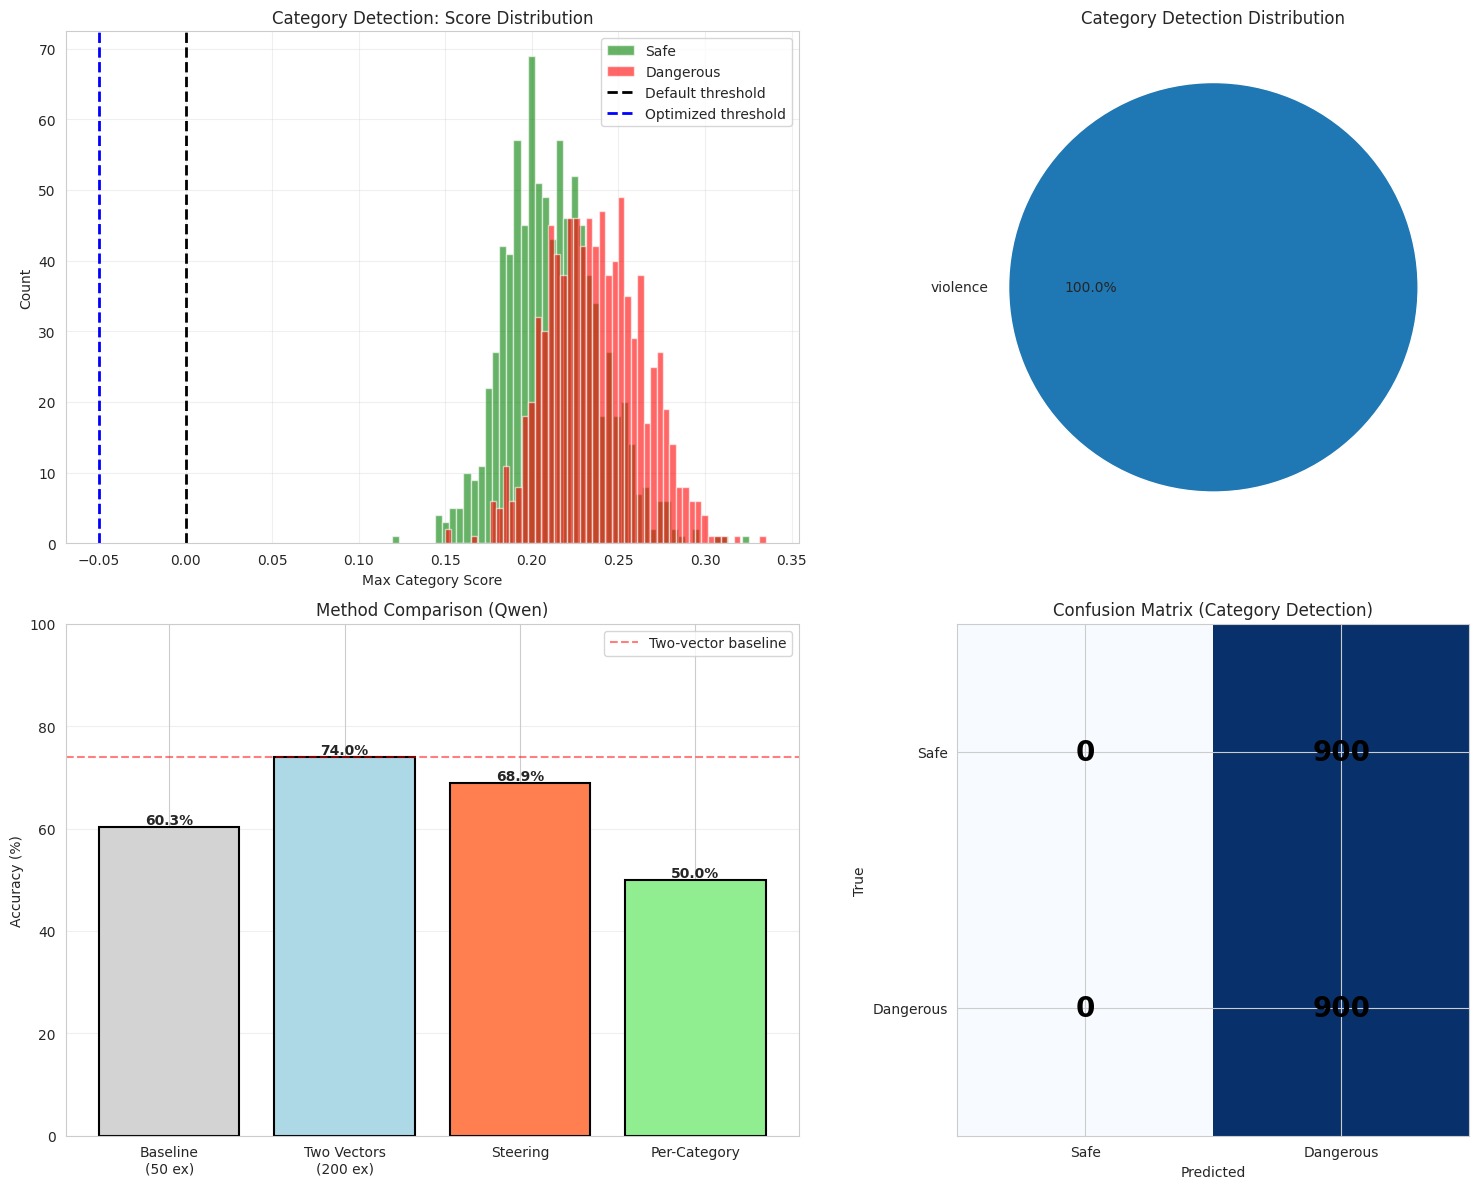


✓ Per-category detection complete!

FINAL RESULTS
Baseline (50 examples):        60.3%
Two Vectors (200 examples):    74.0%
Per-Category (200 examples):   50.0%

Improvement: -24.0%
Total gain from baseline: -10.3%


In [25]:
# ============================================================
# 17. METHOD D: PER-CATEGORY SAFETY DETECTION
# ============================================================

print("="*60)
print("PER-CATEGORY SAFETY DETECTION")
print("="*60)

print("\nConcept: Instead of one 'dangerous' vector,")
print("create specialized vectors for each threat category:")
print("  - Violence")
print("  - Drugs/Substances")
print("  - Fraud/Deception")
print("  - Self-harm")
print("  - Hate/Discrimination")
print()

# ============================================================
# Step 1: Categorize Training Data
# ============================================================

print("="*60)
print("STEP 1: CATEGORIZING TRAINING DATA")
print("="*60)

# Define category keywords for automatic labeling
category_keywords = {
    'violence': [
        'kill', 'murder', 'attack', 'weapon', 'gun', 'knife', 'bomb', 'explosive',
        'hurt', 'harm', 'fight', 'assault', 'shoot', 'stab', 'poison', 'destroy',
        'damage', 'injure', 'wound'
    ],
    'drugs': [
        'drug', 'meth', 'cocaine', 'heroin', 'narcotic', 'illegal substance',
        'high', 'overdose', 'synthesize', 'manufacture', 'controlled substance',
        'marijuana', 'cannabis', 'LSD', 'ecstasy', 'prescription abuse'
    ],
    'fraud': [
        'steal', 'fraud', 'scam', 'hack', 'phishing', 'identity theft',
        'counterfeit', 'fake', 'forge', 'cheat', 'deceive', 'blackmail',
        'embezzle', 'money laundering', 'credit card', 'break into'
    ],
    'self_harm': [
        'suicide', 'self-harm', 'kill myself', 'end my life', 'hurt myself',
        'cutting', 'overdose', 'self-injury', 'harm oneself'
    ],
    'hate': [
        'racist', 'sexist', 'discriminate', 'hate speech', 'slur',
        'bigot', 'prejudice', 'supremacy', 'genocide'
    ]
}

def categorize_query(query, keywords_dict):
    """
    Categorize a query based on keyword matching
    Returns list of matching categories
    """
    query_lower = query.lower()
    categories = []
    
    for category, keywords in keywords_dict.items():
        if any(keyword in query_lower for keyword in keywords):
            categories.append(category)
    
    return categories if categories else ['general']

# Categorize dangerous training examples
print("\nCategorizing dangerous training examples...")
categorized_dangerous = {cat: [] for cat in category_keywords.keys()}
categorized_dangerous['general'] = []  # Uncategorized

for query in dangerous_train:
    cats = categorize_query(query, category_keywords)
    for cat in cats:
        categorized_dangerous[cat].append(query)

# Print statistics
print("\nCategory distribution:")
for cat, queries in categorized_dangerous.items():
    print(f"  {cat.capitalize():<15} {len(queries):>3} examples")

total_categorized = sum(len(q) for cat, q in categorized_dangerous.items() if cat != 'general')
print(f"\nTotal dangerous: {len(dangerous_train)}")
print(f"Categorized: {total_categorized}")
print(f"General/Multiple: {len(categorized_dangerous['general'])}")

# ============================================================
# Step 2: Extract Category Vectors
# ============================================================

print("\n" + "="*60)
print("STEP 2: EXTRACTING CATEGORY VECTORS")
print("="*60)

def extract_category_vectors(model, tokenizer, safe_examples, category_examples_dict, layer_idx, batch_size=16):
    """
    Extract vectors for each category using contrastive approach
    Each category vector = mean(category_examples) - mean(safe_examples)
    """
    print(f"\nExtracting category vectors from Layer {layer_idx}...")
    
    # Get safe baseline activation
    print("\nExtracting safe baseline...")
    safe_activations = []
    for i in tqdm(range(0, len(safe_examples), batch_size), desc="Safe examples"):
        batch = safe_examples[i:i+batch_size]
        with torch.no_grad():
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
            safe_activations.append(activation)
    
    safe_activations = torch.cat(safe_activations, dim=0)
    safe_mean = safe_activations.mean(dim=0, keepdim=True)
    
    # Extract vector for each category
    category_vectors = {}
    
    for category, examples in category_examples_dict.items():
        if len(examples) < 5:  # Need minimum examples
            print(f"  Skipping {category}: only {len(examples)} examples")
            continue
        
        print(f"\n  Processing {category} ({len(examples)} examples)...")
        
        # Get category activations
        cat_activations = []
        for i in tqdm(range(0, len(examples), batch_size), desc=f"  {category}"):
            batch = examples[i:i+batch_size]
            with torch.no_grad():
                inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                outputs = model(**inputs, output_hidden_states=True)
                activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
                cat_activations.append(activation)
        
        cat_activations = torch.cat(cat_activations, dim=0)
        cat_mean = cat_activations.mean(dim=0, keepdim=True)
        
        # Category vector = contrastive (category - safe)
        category_vector = cat_mean - safe_mean
        
        # Calculate separation
        separation = torch.cosine_similarity(cat_mean, safe_mean, dim=1).item()
        
        category_vectors[category] = {
            'vector': category_vector,
            'separation': separation,
            'n_examples': len(examples)
        }
        
        print(f"    Separation: {separation:.4f}")
    
    return category_vectors, safe_mean

# Extract for Qwen (our best model)
print("\n" + "="*60)
print("QWEN CATEGORY VECTORS (Layer 27)")
print("="*60)

qwen_category_vectors, qwen_safe_baseline = extract_category_vectors(
    qwen_model, qwen_tokenizer,
    safe_train,
    categorized_dangerous,
    layer_idx=27,
    batch_size=16
)

# ============================================================
# Step 3: Test with Category Detection
# ============================================================

print("\n" + "="*60)
print("STEP 3: TESTING CATEGORY-BASED DETECTION")
print("="*60)

def test_category_detection(model, tokenizer, queries, labels, category_vectors, safe_baseline, layer_idx):
    """
    Test using category-specific detection
    For each query, calculate similarity to all category vectors
    Dangerous if ANY category score exceeds threshold
    """
    results = {
        'queries': [],
        'true_labels': [],
        'predictions': [],
        'scores': [],  # Max category score
        'category_scores': [],  # All category scores
        'detected_category': [],  # Which category triggered
        'correct': []
    }
    
    category_names = list(category_vectors.keys())
    
    for query, label in tqdm(zip(queries, labels), total=len(queries), desc=f"Testing Layer {layer_idx}"):
        # Get query activation
        with torch.no_grad():
            inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        # Calculate similarity to each category
        cat_scores = {}
        for cat_name, cat_data in category_vectors.items():
            cat_vec = cat_data['vector']
            # Positive score = query similar to category
            score = torch.cosine_similarity(activation, cat_vec, dim=1).item()
            cat_scores[cat_name] = score
        
        # Get max category score (most dangerous match)
        max_category = max(cat_scores, key=cat_scores.get)
        max_score = cat_scores[max_category]
        
        # Prediction: dangerous if ANY category score is high
        # Using 0 as threshold (positive = dangerous direction)
        prediction = 1 if max_score > 0 else 0
        
        results['queries'].append(query)
        results['true_labels'].append(label)
        results['predictions'].append(prediction)
        results['scores'].append(max_score)
        results['category_scores'].append(cat_scores)
        results['detected_category'].append(max_category if max_score > 0 else None)
        results['correct'].append(prediction == label)
    
    accuracy = sum(results['correct']) / len(results['correct'])
    
    return results, accuracy

# Test Qwen with category detection
qwen_cat_results, qwen_cat_acc = test_category_detection(
    qwen_model, qwen_tokenizer,
    test_queries, test_labels,
    qwen_category_vectors,
    qwen_safe_baseline,
    layer_idx=27
)

print(f"\nQwen Category Detection:")
print(f"  Default (threshold=0): {qwen_cat_acc*100:.1f}%")

# Optimize threshold
qwen_cat_thresh, qwen_cat_acc_opt = optimize_threshold(
    qwen_cat_results['scores'],
    test_labels
)

print(f"  Optimized (threshold={qwen_cat_thresh:.6f}): {qwen_cat_acc_opt*100:.1f}%")

# ============================================================
# Step 4: Analysis & Comparison
# ============================================================

print("\n" + "="*60)
print("COMPARISON: METHODS")
print("="*60)

comparison_methods = pd.DataFrame({
    'Method': [
        'Baseline (50 examples)',
        'Two Vectors (200 examples)',
        'Steering Vector',
        'Per-Category Detection'
    ],
    'Qwen Accuracy': [
        60.3,
        74.0,
        68.9,
        qwen_cat_acc_opt * 100
    ],
    'Improvement vs Baseline': [
        0,
        74.0 - 60.3,
        68.9 - 60.3,
        (qwen_cat_acc_opt * 100) - 60.3
    ]
})

print(comparison_methods.to_string(index=False))

# Calculate detailed metrics
qwen_cat_metrics = calculate_metrics_optimized(
    qwen_cat_results['scores'],
    test_labels,
    qwen_cat_thresh
)

print("\n" + "="*60)
print("DETAILED METRICS - CATEGORY DETECTION")
print("="*60)

print("\nQwen (Layer 27, Category Detection):")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {qwen_cat_metrics['safe']['precision']:<12.3f} {qwen_cat_metrics['safe']['recall']:<12.3f} {qwen_cat_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {qwen_cat_metrics['dangerous']['precision']:<12.3f} {qwen_cat_metrics['dangerous']['recall']:<12.3f} {qwen_cat_metrics['dangerous']['f1']:<12.3f}")
print(f"{'Weighted F1':<15} {qwen_cat_metrics['weighted_f1']:.3f}")

# Category usage analysis
print("\n" + "="*60)
print("CATEGORY DETECTION ANALYSIS")
print("="*60)

# Count how often each category was detected
category_detections = {}
for cat in qwen_cat_results['detected_category']:
    if cat is not None:
        category_detections[cat] = category_detections.get(cat, 0) + 1

print("\nCategory detection frequency (on positives):")
for cat, count in sorted(category_detections.items(), key=lambda x: x[1], reverse=True):
    pct = count / sum(category_detections.values()) * 100
    print(f"  {cat.capitalize():<15} {count:>4} detections ({pct:>5.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Score distribution
ax = axes[0, 0]
qwen_cat_scores = np.array(qwen_cat_results['scores'])
qwen_cat_labels = np.array(qwen_cat_results['true_labels'])

ax.hist(qwen_cat_scores[qwen_cat_labels == 0], bins=50, alpha=0.6, label='Safe', color='green')
ax.hist(qwen_cat_scores[qwen_cat_labels == 1], bins=50, alpha=0.6, label='Dangerous', color='red')
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Default threshold')
ax.axvline(qwen_cat_thresh, color='blue', linestyle='--', linewidth=2, label='Optimized threshold')
ax.set_xlabel('Max Category Score')
ax.set_ylabel('Count')
ax.set_title('Category Detection: Score Distribution')
ax.legend()
ax.grid(alpha=0.3)

# Category usage pie chart
ax = axes[0, 1]
if category_detections:
    ax.pie(category_detections.values(), labels=category_detections.keys(), autopct='%1.1f%%')
    ax.set_title('Category Detection Distribution')
else:
    ax.text(0.5, 0.5, 'No category detections', ha='center', va='center')
    ax.set_title('Category Detection Distribution')

# Performance comparison
ax = axes[1, 0]
methods = ['Baseline\n(50 ex)', 'Two Vectors\n(200 ex)', 'Steering', 'Per-Category']
accuracies = [60.3, 74.0, 68.9, qwen_cat_acc_opt * 100]
colors = ['lightgray', 'lightblue', 'coral', 'lightgreen']

bars = ax.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax.axhline(y=74.0, color='red', linestyle='--', alpha=0.5, label='Two-vector baseline')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Method Comparison (Qwen)')
ax.set_ylim([0, 100])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontweight='bold')

# Confusion matrix style
ax = axes[1, 1]
predictions_opt = (qwen_cat_scores > qwen_cat_thresh).astype(int)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(qwen_cat_labels, predictions_opt)

im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Safe', 'Dangerous'])
ax.set_yticklabels(['Safe', 'Dangerous'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Category Detection)')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/category_detection.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
category_results = {
    'category_vectors': qwen_category_vectors,
    'safe_baseline': qwen_safe_baseline,
    'results': qwen_cat_results,
    'accuracy': qwen_cat_acc_opt,
    'threshold': qwen_cat_thresh,
    'metrics': qwen_cat_metrics,
    'category_distribution': categorized_dangerous
}

with open('/kaggle/working/category_detection_results.pkl', 'wb') as f:
    pickle.dump(category_results, f)

print("\n✓ Per-category detection complete!")
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Baseline (50 examples):        60.3%")
print(f"Two Vectors (200 examples):    74.0%")
print(f"Per-Category (200 examples):   {qwen_cat_acc_opt*100:.1f}%")
print(f"\nImprovement: {(qwen_cat_acc_opt*100 - 74.0):+.1f}%")
print(f"Total gain from baseline: {(qwen_cat_acc_opt*100 - 60.3):+.1f}%")

In [26]:
# ============================================================
# 18. MINE CATEGORIES FROM 2000-EXAMPLE DATASET
# ============================================================

print("="*60)
print("EXTRACTING CATEGORIES FROM EXISTING DATASETS")
print("="*60)

print("\nWe have 3 data sources:")
print("1. Manual (100 examples) - keyword-based")
print("2. RealToxicityPrompts (~475 dangerous) - has toxicity info")
print("3. ToxiGen (~475 dangerous) - has target group labels")
print()

# ============================================================
# Step 1: Load Full Datasets Again
# ============================================================

print("="*60)
print("STEP 1: LOADING DATASETS WITH METADATA")
print("="*60)

from datasets import load_dataset

# Load ToxiGen with full metadata
print("\nLoading ToxiGen...")
toxigen_full = load_dataset("skg/toxigen-data", "annotated", split="train")
print(f"✓ Loaded {len(toxigen_full)} examples")

# Check what fields are available
print("\nToxiGen fields:")
sample = toxigen_full[0]
for key in sample.keys():
    print(f"  - {key}: {type(sample[key])}")

# Load RealToxicity
print("\nLoading RealToxicityPrompts...")
rtp_full = load_dataset("allenai/real-toxicity-prompts", split="train")
print(f"✓ Loaded {len(rtp_full)} examples")

print("\nRealToxicity fields:")
sample = rtp_full[0]
print(f"  Keys: {list(sample.keys())}")

# ============================================================
# Step 2: Extract with Category Labels
# ============================================================

print("\n" + "="*60)
print("STEP 2: EXTRACTING DANGEROUS EXAMPLES WITH CATEGORIES")
print("="*60)

# Initialize category storage
categorized_training = {
    'violence': [],
    'hate': [],
    'sexual': [],
    'drugs': [],
    'profanity': [],
    'identity_attack': [],
    'threat': [],
    'general': []
}

safe_training_full = []

# --------------------------------------------------------
# Extract from ToxiGen (has target_group and toxicity labels)
# --------------------------------------------------------
print("\n" + "="*60)
print("Extracting from ToxiGen...")
print("="*60)

toxigen_dangerous = []
toxigen_safe = []

for example in tqdm(toxigen_full, desc="ToxiGen"):
    text = example.get('text', '').strip()
    
    if len(text) < 20 or len(text) > 200:
        continue
    
    toxicity_ai = example.get('toxicity_ai', 5.0)
    toxicity_human = example.get('toxicity_human', 5.0)
    target_group = example.get('target_groups', '')
    
    # Dangerous: toxicity = 5.0
    if toxicity_ai == 5.0 or toxicity_human == 5.0:
        toxigen_dangerous.append({
            'text': text,
            'target_group': target_group,
            'toxicity_ai': toxicity_ai,
            'toxicity_human': toxicity_human
        })
    # Safe: toxicity = 1.0
    elif toxicity_ai == 1.0 and toxicity_human == 1.0:
        toxigen_safe.append(text)
    
    if len(toxigen_dangerous) >= 500 and len(toxigen_safe) >= 500:
        break

print(f"✓ Extracted {len(toxigen_dangerous)} dangerous, {len(toxigen_safe)} safe")

# Categorize ToxiGen examples (they're mostly hate speech)
for item in toxigen_dangerous:
    text = item['text']
    target = str(item.get('target_group', '')).lower()
    
    # ToxiGen is primarily hate speech toward identity groups
    categorized_training['hate'].append(text)

# --------------------------------------------------------
# Extract from RealToxicity (has detailed toxicity breakdown)
# --------------------------------------------------------
print("\n" + "="*60)
print("Extracting from RealToxicityPrompts...")
print("="*60)

rtp_dangerous = []
rtp_safe = []

for i, example in enumerate(tqdm(rtp_full, desc="RealToxicity")):
    if i >= 50000:
        break
    
    prompt_data = example.get('prompt', example)
    
    if isinstance(prompt_data, dict):
        text = prompt_data.get('text', '')
        toxicity = prompt_data.get('toxicity')
    else:
        continue
    
    if not text or len(text) < 20 or len(text) > 200 or toxicity is None:
        continue
    
    text = text.strip()
    
    # Safe
    if toxicity < 0.3:
        rtp_safe.append(text)
        if len(rtp_safe) >= 500:
            continue
    
    # Dangerous - check if we have detailed breakdown
    elif toxicity > 0.6:
        # RealToxicity might have category scores
        item = {
            'text': text,
            'toxicity': toxicity
        }
        
        # Try to get detailed scores if available
        if isinstance(prompt_data, dict):
            item['severe_toxicity'] = prompt_data.get('severe_toxicity')
            item['obscene'] = prompt_data.get('obscene')
            item['threat'] = prompt_data.get('threat')
            item['insult'] = prompt_data.get('insult')
            item['identity_attack'] = prompt_data.get('identity_attack')
            item['sexual_explicit'] = prompt_data.get('sexual_explicit')
        
        rtp_dangerous.append(item)
        
        if len(rtp_dangerous) >= 500:
            break

print(f"✓ Extracted {len(rtp_dangerous)} dangerous, {len(rtp_safe)} safe")

# Categorize RealToxicity examples based on available scores
print("\nCategorizing RealToxicity examples...")
for item in tqdm(rtp_dangerous, desc="Categorizing"):
    text = item['text']
    
    # Check detailed scores if available
    threat_score = item.get('threat', 0) or 0
    identity_score = item.get('identity_attack', 0) or 0
    sexual_score = item.get('sexual_explicit', 0) or 0
    obscene_score = item.get('obscene', 0) or 0
    
    # Categorize based on highest score
    scores = {
        'threat': threat_score,
        'identity_attack': identity_score,
        'sexual': sexual_score,
        'profanity': obscene_score
    }
    
    max_category = max(scores, key=scores.get) if max(scores.values()) > 0.3 else 'general'
    
    categorized_training[max_category].append(text)

# --------------------------------------------------------
# Add manual examples with keyword-based categorization
# --------------------------------------------------------
print("\n" + "="*60)
print("Adding manual examples...")
print("="*60)

violence_keywords = ['bomb', 'weapon', 'kill', 'murder', 'attack', 'hurt', 'harm', 'explosive', 'poison', 'injure']
drug_keywords = ['drug', 'meth', 'cocaine', 'heroin', 'narcotic', 'substance']
sexual_keywords = ['sexual', 'explicit', 'pornographic', 'nude']

for query in dangerous_train:
    query_lower = query.lower()
    
    if any(kw in query_lower for kw in violence_keywords):
        categorized_training['violence'].append(query)
    elif any(kw in query_lower for kw in drug_keywords):
        categorized_training['drugs'].append(query)
    elif any(kw in query_lower for kw in sexual_keywords):
        categorized_training['sexual'].append(query)
    else:
        categorized_training['general'].append(query)

# Combine all safe examples
safe_training_full = list(set(toxigen_safe + rtp_safe + safe_train))

# ============================================================
# Step 3: Balance and Sample Categories
# ============================================================

print("\n" + "="*60)
print("STEP 3: CATEGORY DISTRIBUTION")
print("="*60)

print("\nRaw category counts:")
for cat, examples in sorted(categorized_training.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {cat.capitalize():<20} {len(examples):>4} examples")

print(f"\nTotal dangerous: {sum(len(v) for v in categorized_training.values())}")
print(f"Total safe: {len(safe_training_full)}")

# Remove categories with too few examples (< 20)
min_examples = 20
filtered_categories = {k: v for k, v in categorized_training.items() if len(v) >= min_examples}

print(f"\n" + "="*60)
print(f"FILTERED CATEGORIES (>= {min_examples} examples):")
print("="*60)
for cat, examples in sorted(filtered_categories.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {cat.capitalize():<20} {len(examples):>4} examples")

# Sample to create balanced training set
# Use 100 examples per category (if available)
samples_per_category = 100

balanced_training = {}
for cat, examples in filtered_categories.items():
    if len(examples) >= samples_per_category:
        sampled = random.sample(examples, samples_per_category)
    else:
        sampled = examples
    balanced_training[cat] = sampled

print(f"\n" + "="*60)
print(f"BALANCED TRAINING SET ({samples_per_category} per category):")
print("="*60)
for cat, examples in sorted(balanced_training.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {cat.capitalize():<20} {len(examples):>4} examples")

# Sample safe examples to match total dangerous
total_dangerous = sum(len(v) for v in balanced_training.values())
safe_training_balanced = random.sample(safe_training_full, min(total_dangerous, len(safe_training_full)))

print(f"\nSafe examples: {len(safe_training_balanced)}")
print(f"Total training: {len(safe_training_balanced) + total_dangerous}")

# ============================================================
# Step 4: Save Categorized Dataset
# ============================================================

categorized_dataset = {
    'balanced_training': balanced_training,
    'safe_training': safe_training_balanced,
    'raw_categories': categorized_training,
    'all_safe': safe_training_full
}

with open('/kaggle/working/categorized_dataset.pkl', 'wb') as f:
    pickle.dump(categorized_dataset, f)

print("\n✓ Categorized dataset saved!")
print("\nDataset ready for per-category training!")

EXTRACTING CATEGORIES FROM EXISTING DATASETS

We have 3 data sources:
1. Manual (100 examples) - keyword-based
2. RealToxicityPrompts (~475 dangerous) - has toxicity info
3. ToxiGen (~475 dangerous) - has target group labels

STEP 1: LOADING DATASETS WITH METADATA

Loading ToxiGen...


README.md: 0.00B [00:00, ?B/s]

annotated/test-00000-of-00001.parquet:   0%|          | 0.00/79.7k [00:00<?, ?B/s]

annotated/train-00000-of-00001.parquet:   0%|          | 0.00/689k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/940 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8960 [00:00<?, ? examples/s]

✓ Loaded 8960 examples

ToxiGen fields:
  - text: <class 'str'>
  - target_group: <class 'str'>
  - factual?: <class 'str'>
  - ingroup_effect: <class 'str'>
  - lewd: <class 'str'>
  - framing: <class 'str'>
  - predicted_group: <class 'str'>
  - stereotyping: <class 'str'>
  - intent: <class 'float'>
  - toxicity_ai: <class 'float'>
  - toxicity_human: <class 'float'>
  - predicted_author: <class 'str'>
  - actual_method: <class 'str'>

Loading RealToxicityPrompts...


README.md: 0.00B [00:00, ?B/s]

prompts.jsonl:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99442 [00:00<?, ? examples/s]

✓ Loaded 99442 examples

RealToxicity fields:
  Keys: ['filename', 'begin', 'end', 'challenging', 'prompt', 'continuation']

STEP 2: EXTRACTING DANGEROUS EXAMPLES WITH CATEGORIES

Extracting from ToxiGen...


ToxiGen:  50%|█████     | 4492/8960 [00:00<00:00, 13041.37it/s]


✓ Extracted 500 dangerous, 1138 safe

Extracting from RealToxicityPrompts...


RealToxicity:  50%|█████     | 49868/99442 [00:04<00:04, 11866.25it/s]


✓ Extracted 500 dangerous, 41166 safe

Categorizing RealToxicity examples...


Categorizing: 100%|██████████| 500/500 [00:00<00:00, 417011.73it/s]


Adding manual examples...

STEP 3: CATEGORY DISTRIBUTION

Raw category counts:
  Hate                  500 examples
  Threat                202 examples
  Identity_attack       198 examples
  General               192 examples
  Drugs                   4 examples
  Violence                3 examples
  Sexual                  1 examples
  Profanity               0 examples

Total dangerous: 1100
Total safe: 42179

FILTERED CATEGORIES (>= 20 examples):
  Hate                  500 examples
  Threat                202 examples
  Identity_attack       198 examples
  General               192 examples

BALANCED TRAINING SET (100 per category):
  Hate                  100 examples
  Identity_attack       100 examples
  Threat                100 examples
  General               100 examples

Safe examples: 400
Total training: 800

✓ Categorized dataset saved!

Dataset ready for per-category training!


In [27]:
# ============================================================
# 19. PER-CATEGORY TRAINING (PROPER DATA)
# ============================================================

# Load categorized dataset
with open('/kaggle/working/categorized_dataset.pkl', 'rb') as f:
    cat_data = pickle.load(f)

balanced_training = cat_data['balanced_training']
safe_training_balanced = cat_data['safe_training']

# Extract category vectors (same as before but with better data)
qwen_category_vectors_v2, qwen_safe_baseline_v2 = extract_category_vectors(
    qwen_model, qwen_tokenizer,
    safe_training_balanced,
    balanced_training,
    layer_idx=27,
    batch_size=16
)

# Test
qwen_cat_results_v2, qwen_cat_acc_v2 = test_category_detection(
    qwen_model, qwen_tokenizer,
    test_queries, test_labels,
    qwen_category_vectors_v2,
    qwen_safe_baseline_v2,
    layer_idx=27
)

# Optimize
qwen_cat_thresh_v2, qwen_cat_acc_opt_v2 = optimize_threshold(
    qwen_cat_results_v2['scores'],
    test_labels
)

print(f"\nPer-Category (Proper Data): {qwen_cat_acc_opt_v2*100:.1f}%")
print(f"vs Two-Vector: 74.0%")
print(f"Improvement: {(qwen_cat_acc_opt_v2*100 - 74.0):+.1f}%")


Extracting category vectors from Layer 27...

Extracting safe baseline...


Safe examples: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]



  Processing hate (100 examples)...


  hate: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


    Separation: 0.9846

  Processing identity_attack (100 examples)...


  identity_attack: 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


    Separation: 0.9971

  Processing threat (100 examples)...


  threat: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


    Separation: 0.9969

  Processing general (100 examples)...


  general: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


    Separation: 0.9971


Testing Layer 27: 100%|██████████| 1800/1800 [01:27<00:00, 20.62it/s]


Per-Category (Proper Data): 49.7%
vs Two-Vector: 74.0%
Improvement: -24.3%
